# Задание 5


Подключаем необходимые библиотеки

In [15]:
import warnings
warnings.filterwarnings('ignore')

import re
import os
import pywt
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import pyedflib
from scipy import signal
from scipy.fft import fft, fftfreq

### Задание 1
Сделайте скрипт для формирования обучающей выборки из базы данных ЭЭГ с указанными приступами



### Задание 2
Сформируйте не менее 50 записей с приступами и не менее 50 записей ЭЭГ без приступов. Записи нужно «обрезать» по времени и построить для них вейвлет изображение (можно разбить на диапазоны ритмов мозга, можно не разбивать). В итоге должно быть 100 «картинок».  


### Задание 3
Полученные изображения сложите в отдельные папки (место хранения выбирайте на свое усмотрение). Папки нужны для того, чтобы разделить изображения для записей с приступом и для записей без приступа.


In [20]:
def parse_summary_file():
    edf_files = []
    with open('datasets/chb22-summary.txt', 'r') as file:
        content = file.read()
        files = re.split(r'File Name: ', content)[1:]  # Разделение по файлам
        for file_info in files:
            lines = file_info.split('\n')
            file_name = lines[0].strip()
            seizure_start = []
            seizure_end = []
            num_seizures = 0
            k=0
            for line in lines[1:]:
                if 'Number of Seizures in File' in line:
                    num_seizures = int(line.split(':')[-1].strip())
                    k=num_seizures
                    continue

                if k > 0:
                    if ('Seizure' in line)and('Start Time' in line):
                        seizure_start_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_start.append(seizure_start_i)
                        continue

                    if ('Seizure' in line)and('End Time' in line):
                        seizure_end_i = int(re.search(r'\d+', line.split(':')[-1].strip()).group())
                        seizure_end.append(seizure_end_i)
                        k-=1
                        continue

            edf_files.append({
                'file_name': file_name,
                'seizure_start': seizure_start,
                'seizure_end': seizure_end,
                'num_seizures': num_seizures
            })
    return edf_files

In [22]:
edf_files_list = parse_summary_file()
edf_files_list[:5]

[{'file_name': 'chb22_01.edf',
  'seizure_start': [],
  'seizure_end': [],
  'num_seizures': 0},
 {'file_name': 'chb22_02.edf',
  'seizure_start': [],
  'seizure_end': [],
  'num_seizures': 0},
 {'file_name': 'chb22_03.edf',
  'seizure_start': [],
  'seizure_end': [],
  'num_seizures': 0},
 {'file_name': 'chb22_04.edf',
  'seizure_start': [],
  'seizure_end': [],
  'num_seizures': 0},
 {'file_name': 'chb22_05.edf',
  'seizure_start': [],
  'seizure_end': [],
  'num_seizures': 0}]

In [24]:
def read_edf(file_path):
    with pyedflib.EdfReader(file_path) as f:
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        signals = np.zeros((n, f.getNSamples()[0]))

        for i in range(n):
            signals[i, :] = f.readSignal(i)

    return signals, signal_labels

In [26]:
def butter_bandpass_filter(data, fs, plot_signal=False, order=5):
    # Определение диапазонов фильтрации
    lowcut = [1, 4, 8, 14, 30]
    highcut = [4, 8, 14, 20, 50]
    nyquist = 0.5 * fs

    # Список для хранения отфильтрованных сигналов
    filtered_signals = []

    # Фильтрация для каждого диапазона частот
    for i in range(len(lowcut)):
        low = lowcut[i] / nyquist
        high = highcut[i] / nyquist
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data = signal.lfilter(b, a, data)
        filtered_signals.append(filtered_data)

    # Построение спектров
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    for i, filtered_data in enumerate(filtered_signals):
        # Преобразование Фурье
        signal_fft = fft(filtered_data)
        # Амплитуды и частоты
        amplitudes = np.abs(signal_fft) / len(filtered_data)
        frequencies = fftfreq(len(filtered_data), 1 / fs)

        # Отбираем только положительные частоты
        positive_freqs = frequencies > 0
        frequencies = frequencies[positive_freqs]
        amplitudes = amplitudes[positive_freqs]

    return filtered_signals

In [28]:
def save_wavelet_transform(signal, file_name, output_dir, start_time, end_time, sampling_rate, time_label):
    scale_max = [200, 50, 26, 14, 6]
    scale_min = [50, 26, 14, 6, 3.5]
    wavelet_core = 'morl'
    dt = 1 / sampling_rate
    leg = ["Delta", "Theta","Alpha", "Beta","Gamma"]
    v_max = [240, 120, 40, 30, 20]
    for k in range(len(signal)):
            scales = np.linspace(scale_min[k], scale_max[k], num=25, endpoint=True)
            coef, freqs = pywt.cwt(signal[k], scales, wavelet_core, sampling_period=dt)
            frequencies = pywt.scale2frequency(wavelet_core, scales) / dt

            # Создаем кастомную цветовую карту от синего до красного с пределами мощности от 0 до 20
            colors = [(0, 'blue'), (0.5, 'cyan'), (0.9, 'yellow'), (1, 'darkred')]
            custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors)
            ax = plt.subplot(5, 1, k + 1)

            extent = [start_time, end_time, frequencies[-1], frequencies[0]]  # Устанавливаем частоту на вертикальной оси
            # Используем фиксированные пределы vmin=0 и vmax=20
            img = ax.imshow(np.abs(coef), extent=extent, cmap=custom_cmap, aspect='auto', vmin=0, vmax=v_max[k])
            ax.set_ylabel('Frequency (Hz)')
            ax.set_xlabel('Time (seconds)')
            ax.set_ylim(frequencies[-1], frequencies[0])

            # Сохранение изображения
    output_path = os.path.join(output_dir, f'{file_name}_{time_label}_wavelet.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()

    return output_path

In [30]:
# процедура осреднения сигнала - убираем постоянную составляющую
def mean_delete(filtered_alpha,window_count,sampling_rate,time,plot_signal=False):
    leg = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    leg2 = ['Delta_m', 'Theta_m', 'Alpha_m', 'Beta_m','Gamma_m']
    processed_signals = []

    plt.figure(figsize =(15,7))
    fig, axes = plt.subplots(5, 1, figsize=(12, 12))

    for i in range(5):
        filtered_1 = filtered_alpha[i]
        filtered_2 = measured(filtered_1,window_count,sampling_rate)
        processed_signals.append(filtered_2)
        if plot_signal:
            pylab.subplot (5, 1, i+1)
            plt.plot(time, filtered_1, label = leg[i])
            plt.plot(time, filtered_2, label = leg2[i])
            plt.legend(loc='best')
            plt.xlim([2310, 2311])

    return processed_signals


In [32]:

# процедура выделения из всего сигнала окна для выгрузки части сионала
def measured(signal,window_size,sampling_time):
    window_size = int(window_size * sampling_time)
    a = 0
    b = window_size
    n = signal.size / window_size
    f_signal = np.copy(signal)

    for i in range(int(n)):
        a = i * window_size
        b = (i + 1) * window_size
        f_signal[a:b] = signal[a:b] - np.mean(signal[a:b])

    return f_signal

In [34]:
sampling_rate = 256
window_count = 0.5
flag = 0

<Figure size 1500x700 with 0 Axes>

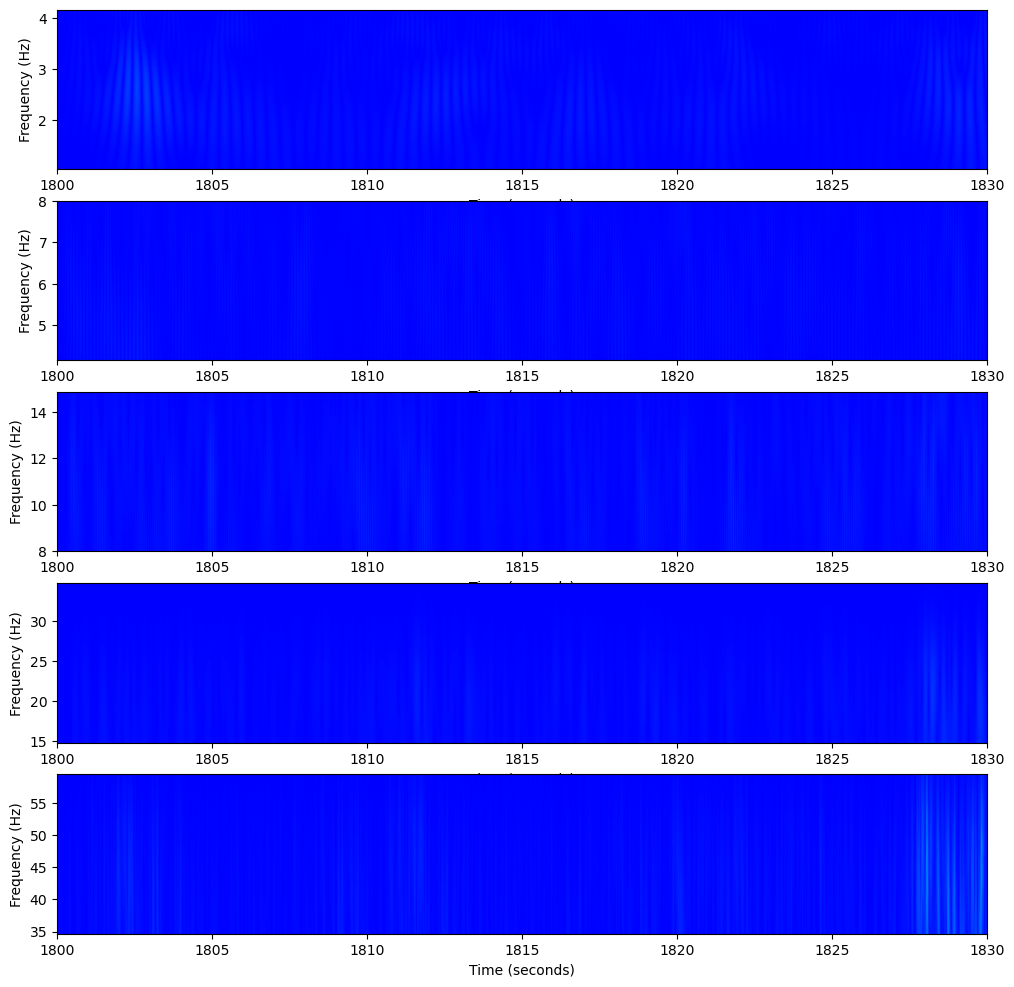

<Figure size 1500x700 with 0 Axes>

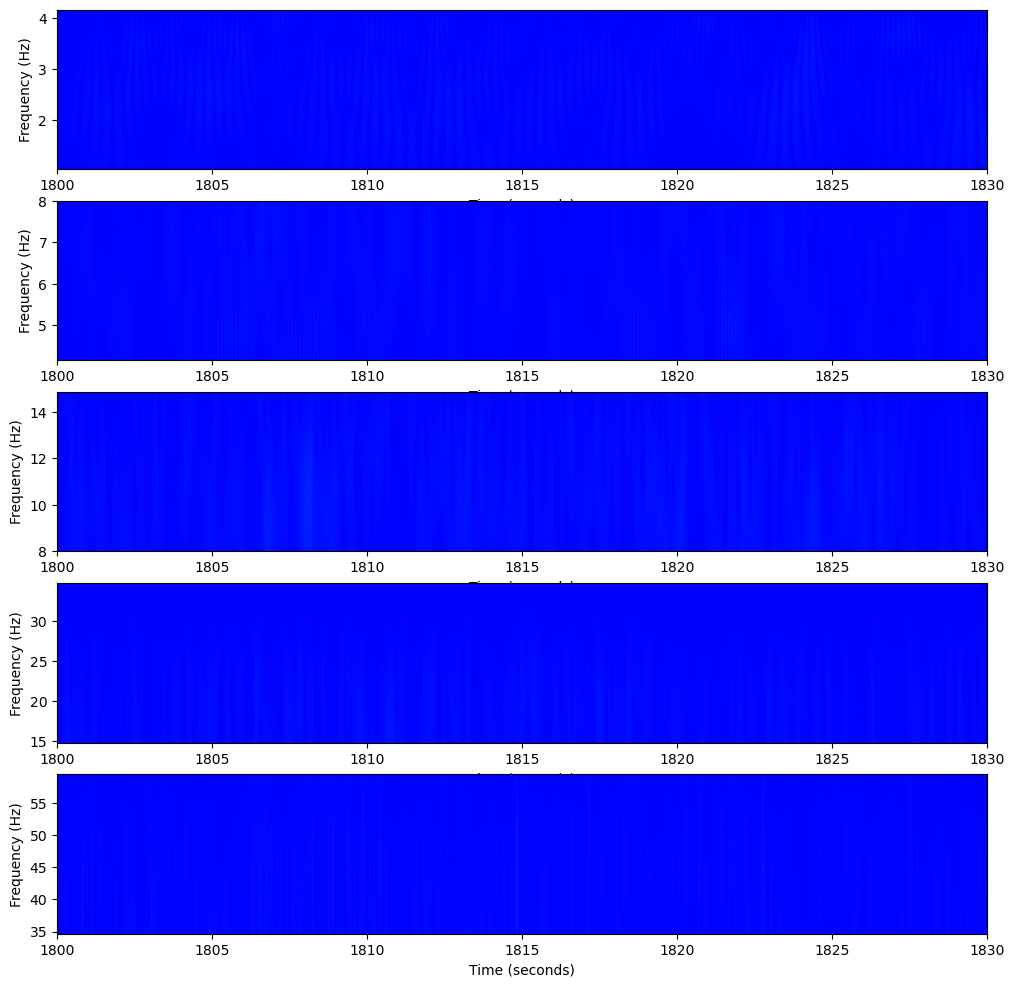

<Figure size 1500x700 with 0 Axes>

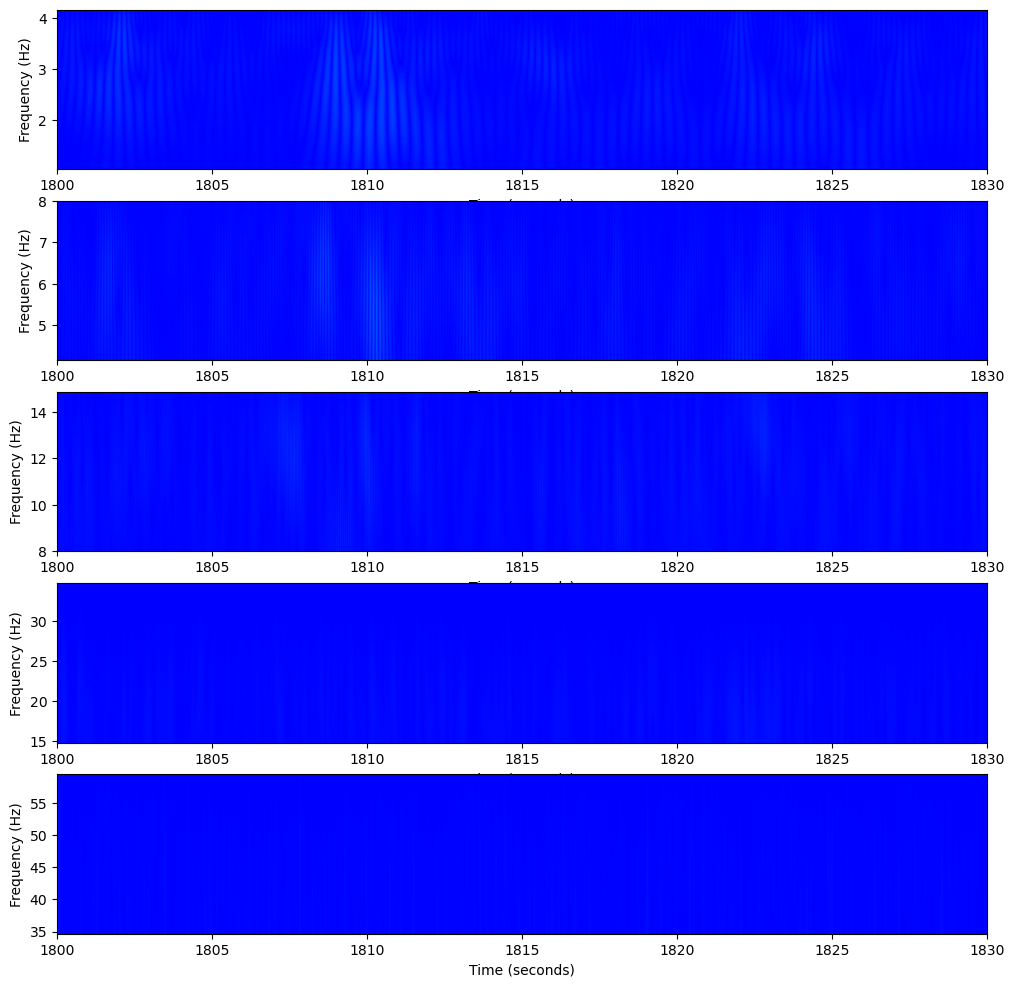

<Figure size 1500x700 with 0 Axes>

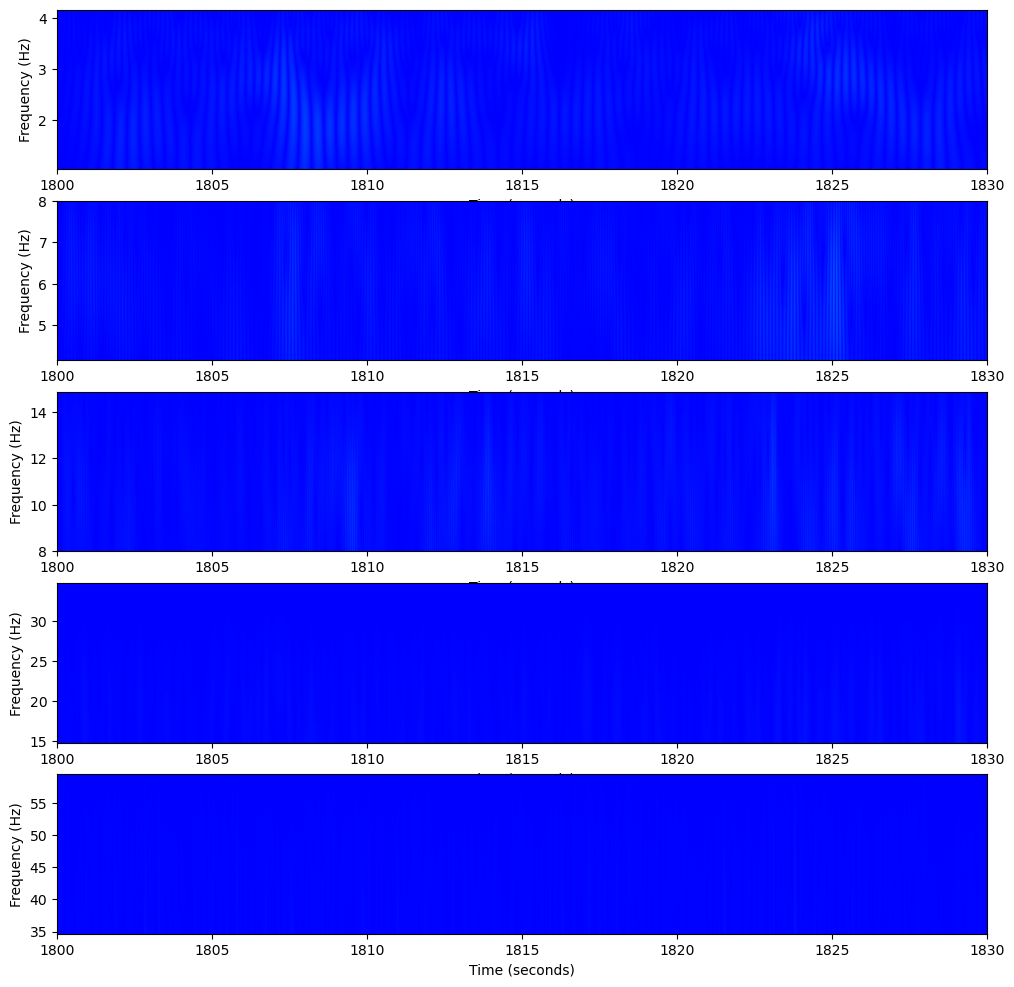

<Figure size 1500x700 with 0 Axes>

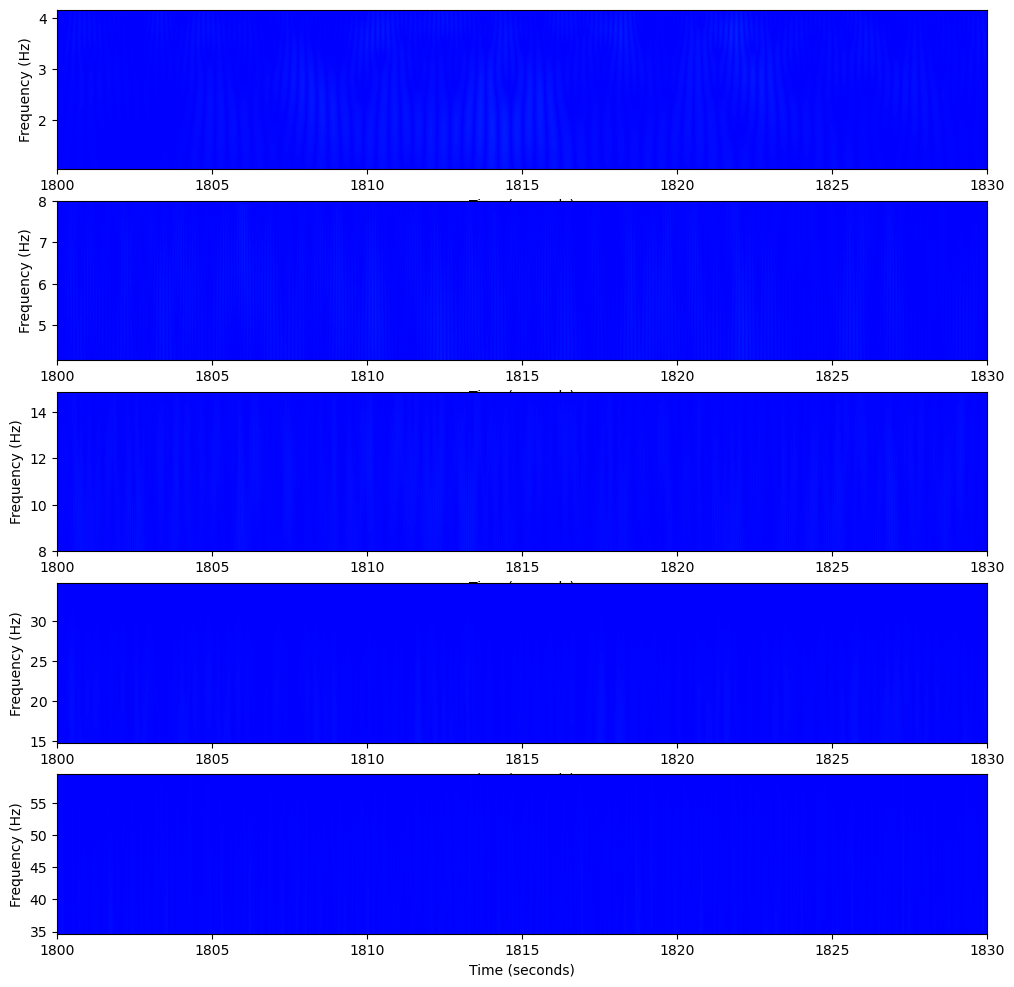

<Figure size 1500x700 with 0 Axes>

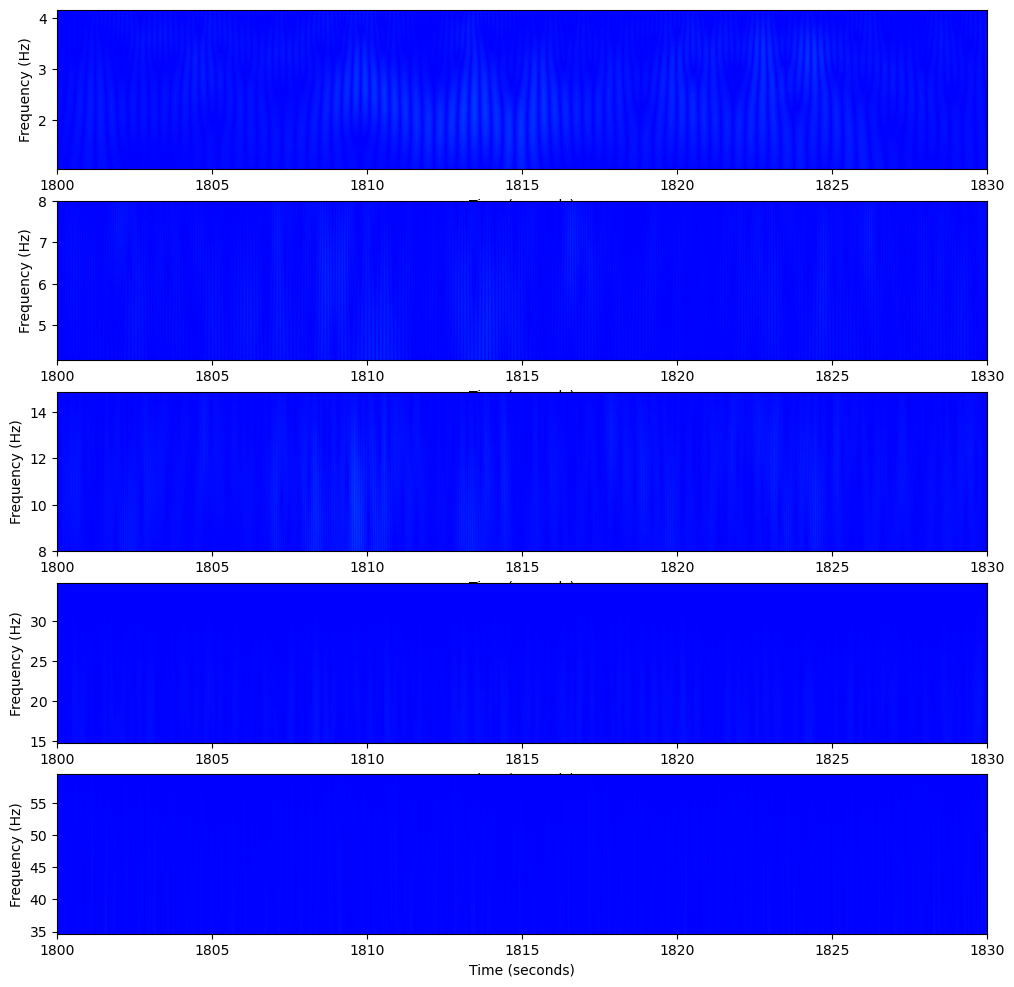

<Figure size 1500x700 with 0 Axes>

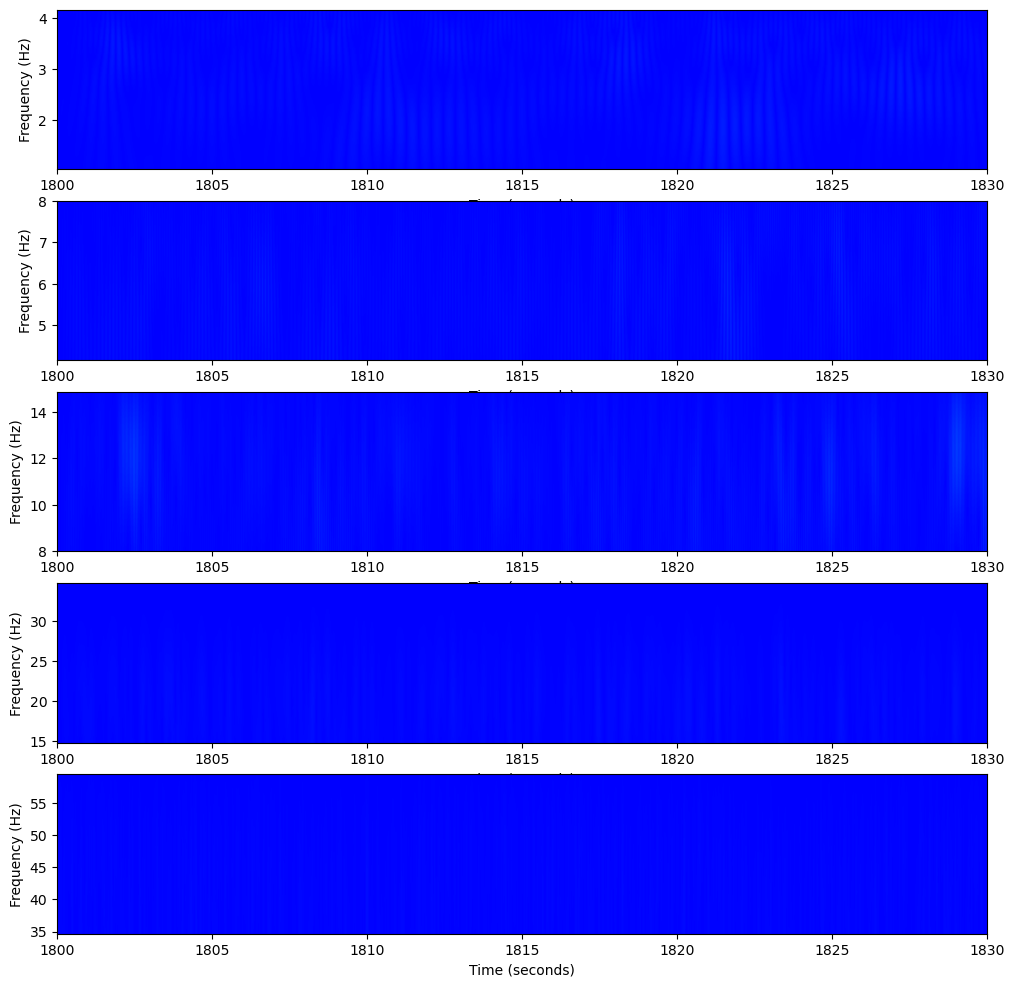

<Figure size 1500x700 with 0 Axes>

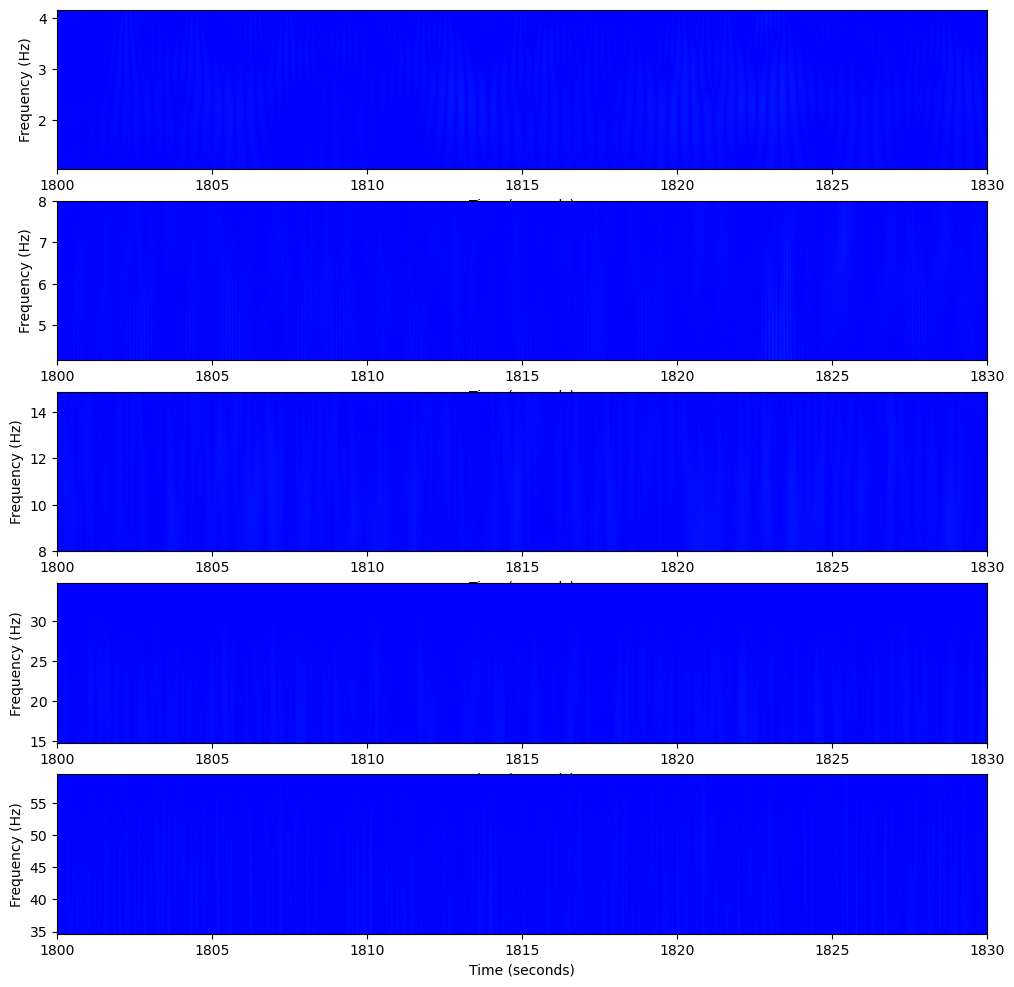

<Figure size 1500x700 with 0 Axes>

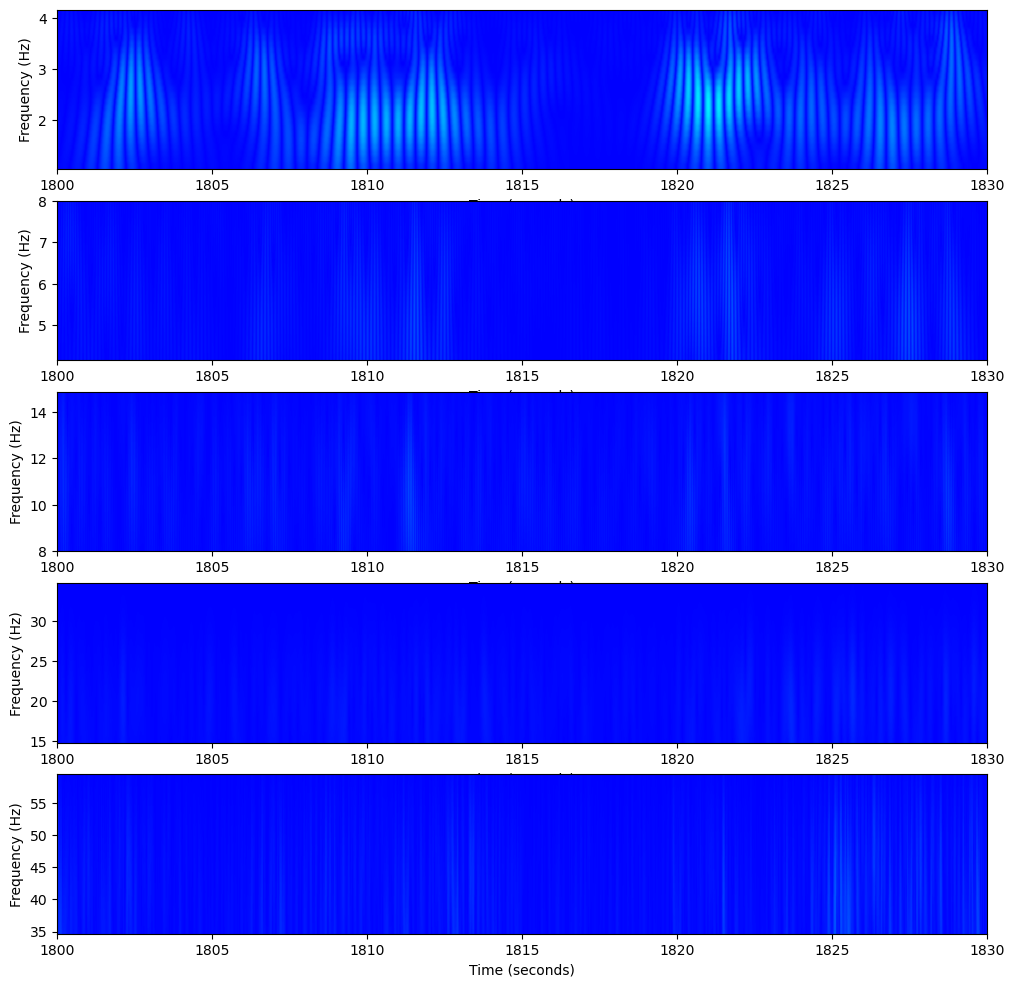

<Figure size 1500x700 with 0 Axes>

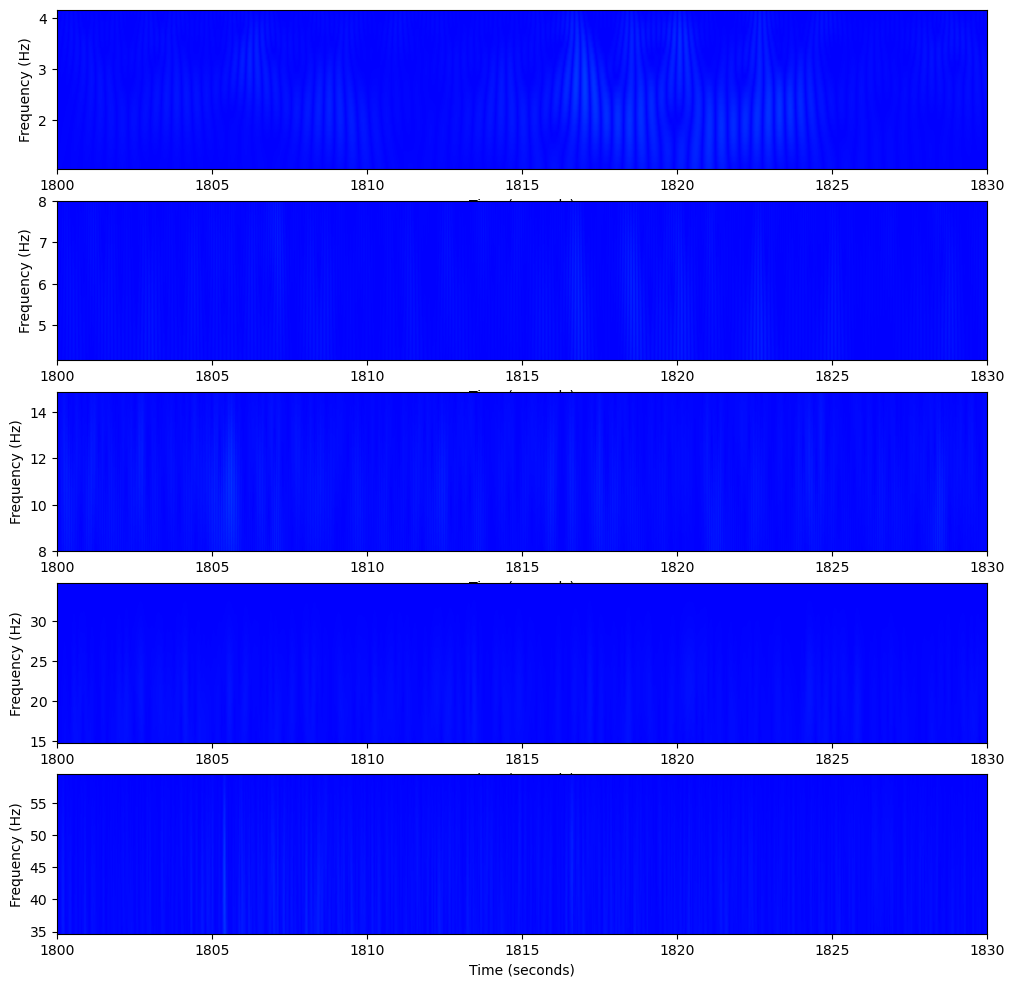

<Figure size 1500x700 with 0 Axes>

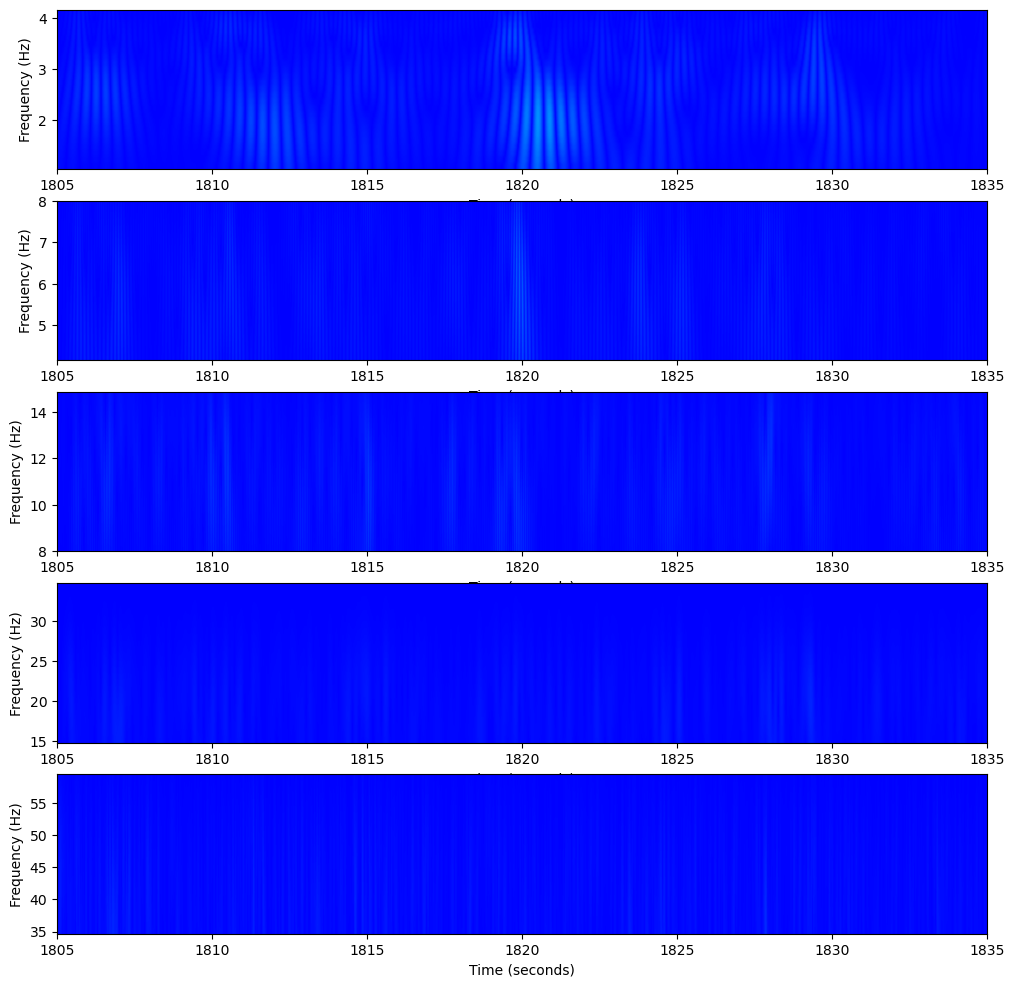

<Figure size 1500x700 with 0 Axes>

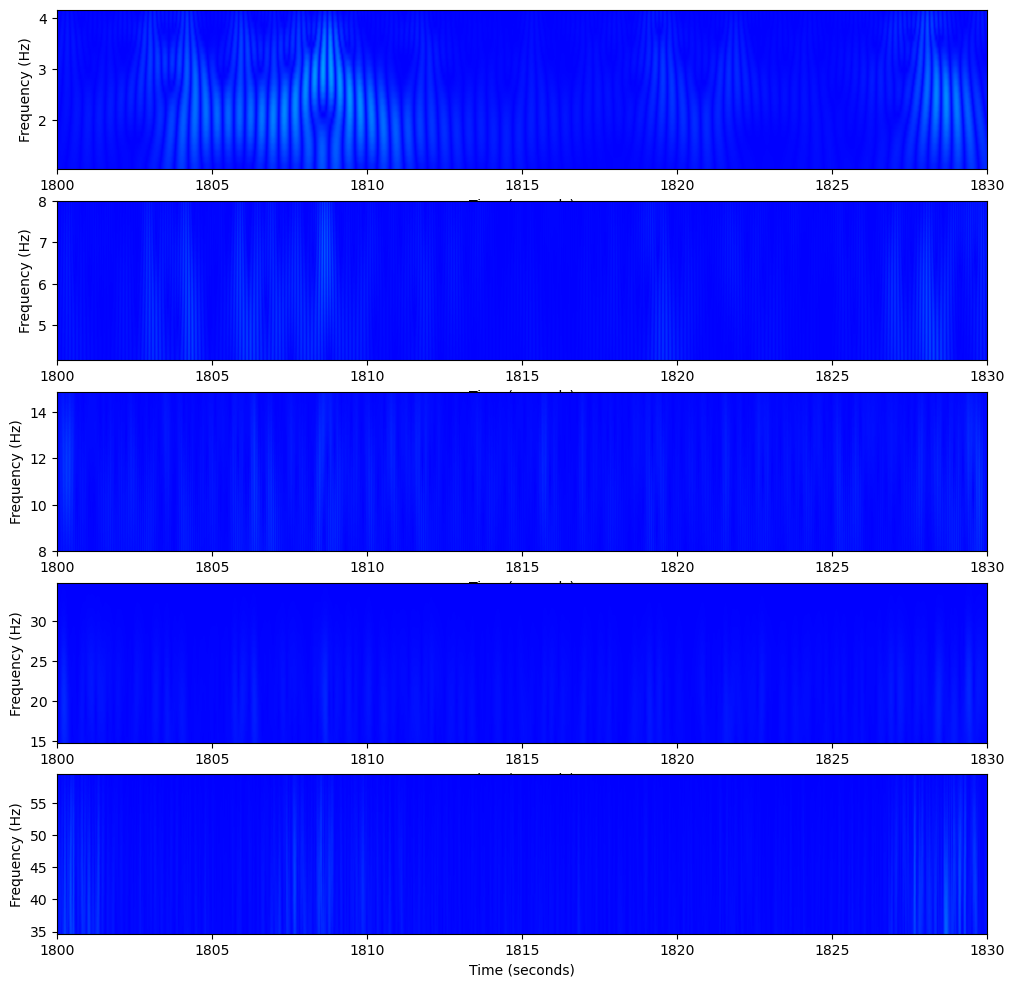

<Figure size 1500x700 with 0 Axes>

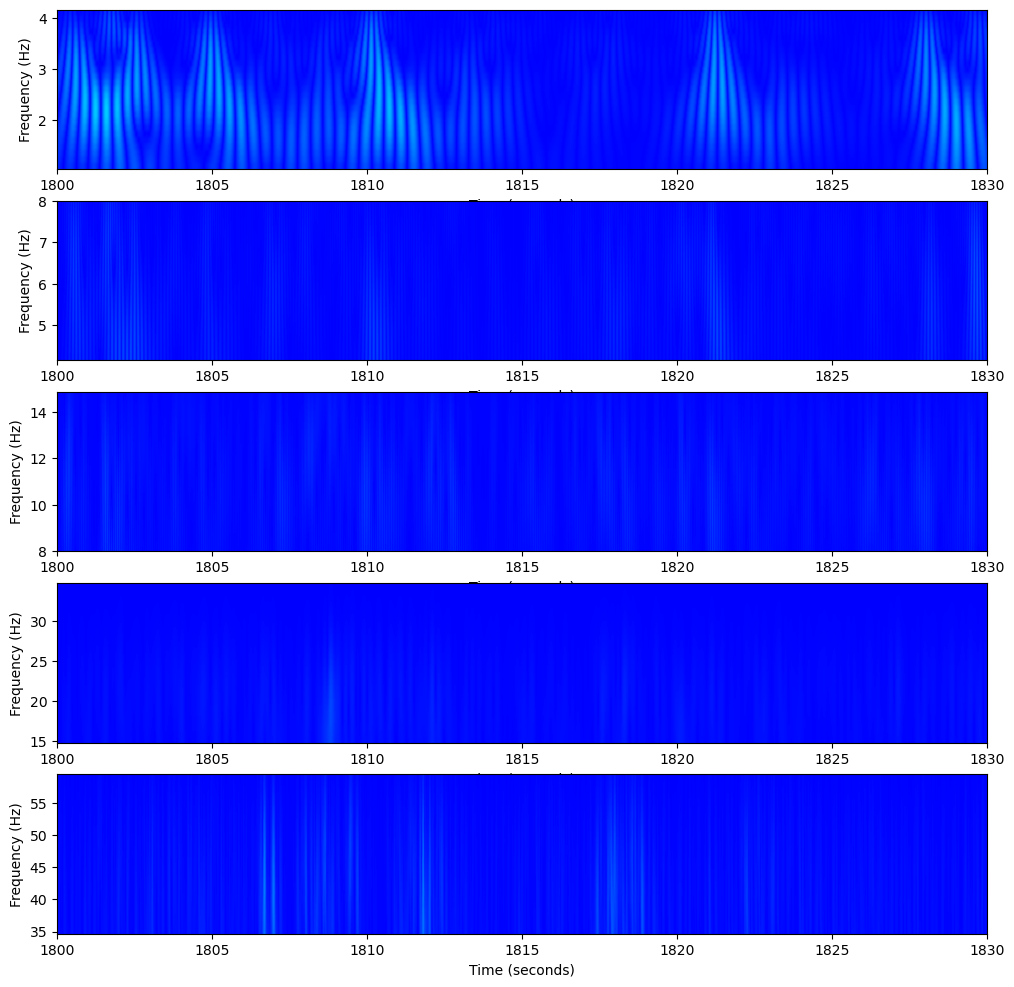

<Figure size 1500x700 with 0 Axes>

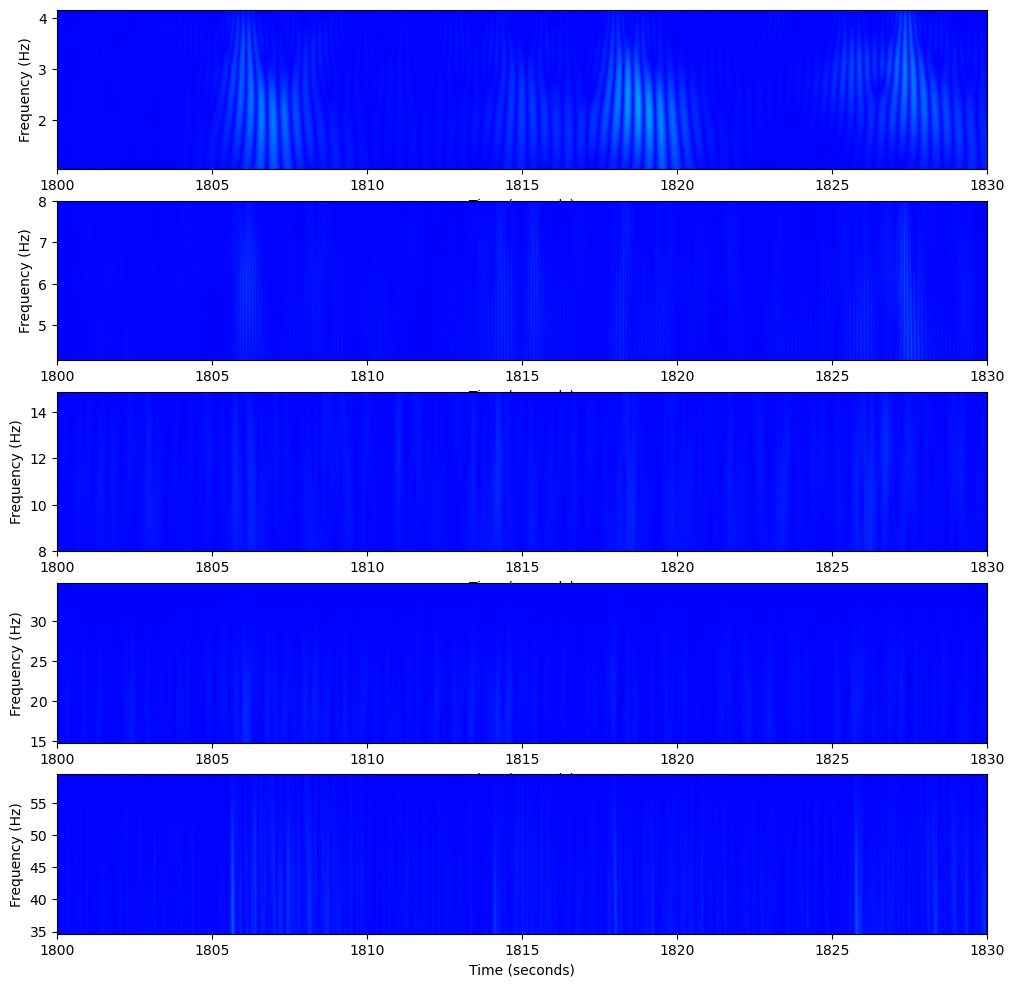

<Figure size 1500x700 with 0 Axes>

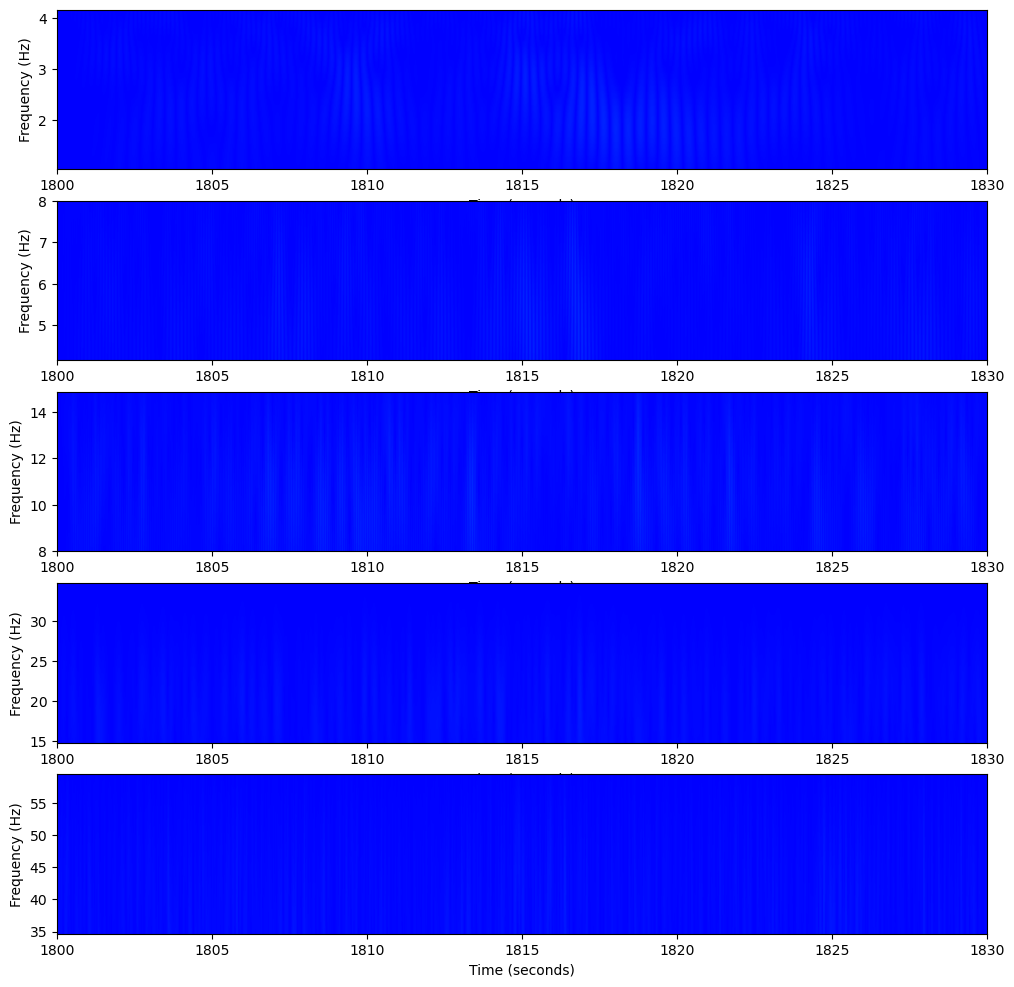

<Figure size 1500x700 with 0 Axes>

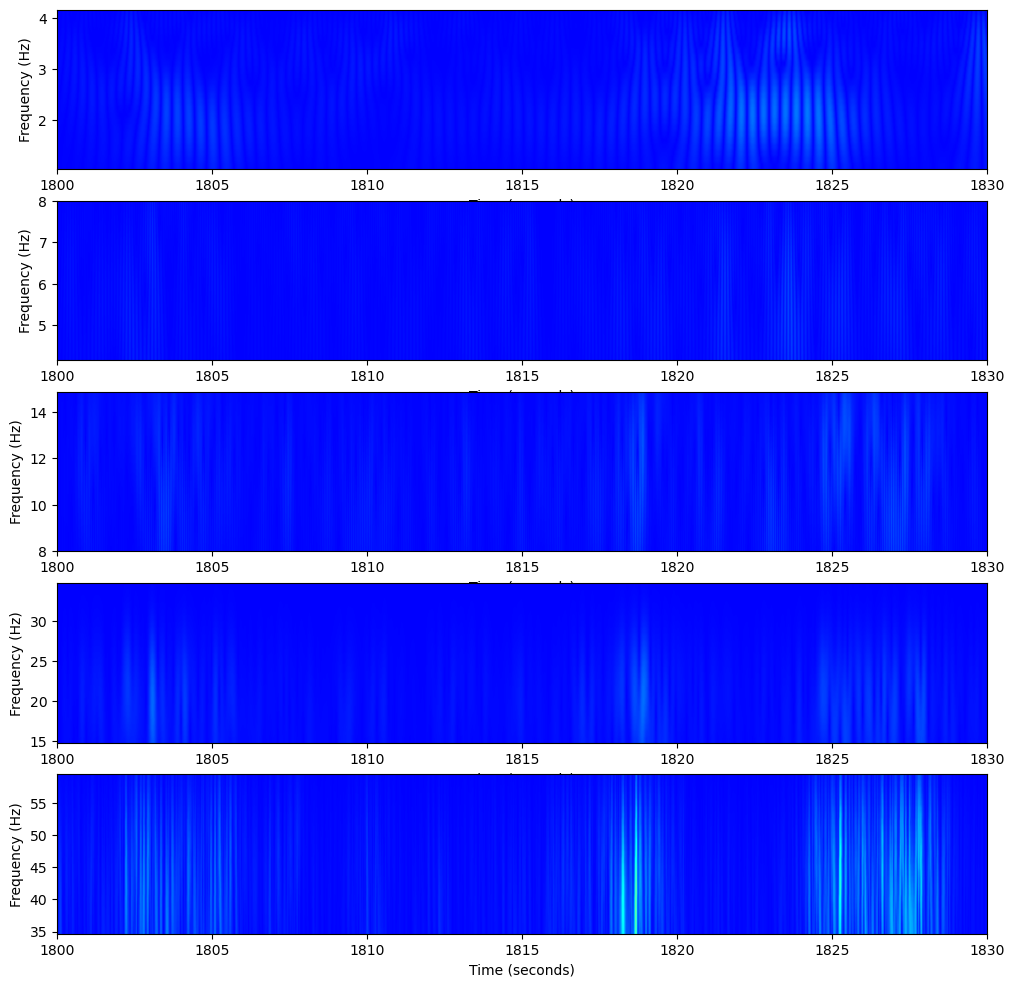

<Figure size 1500x700 with 0 Axes>

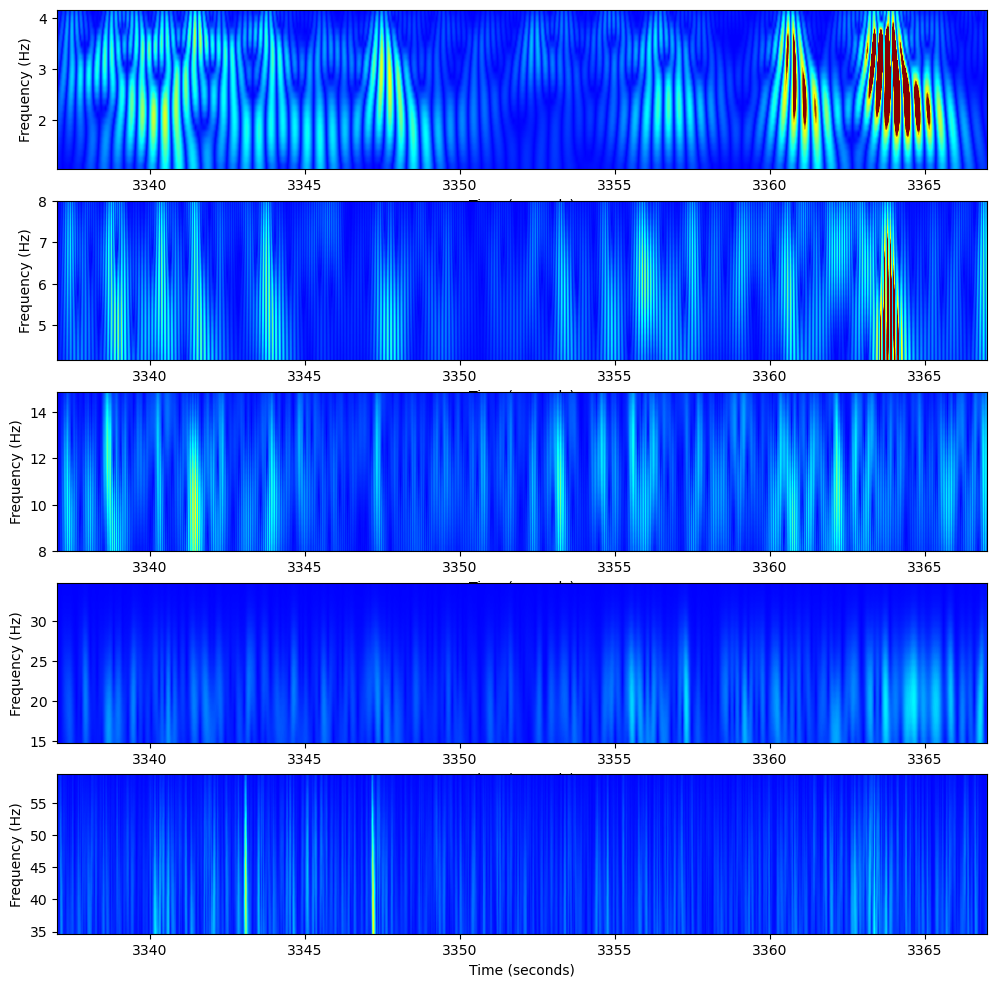

<Figure size 1500x700 with 0 Axes>

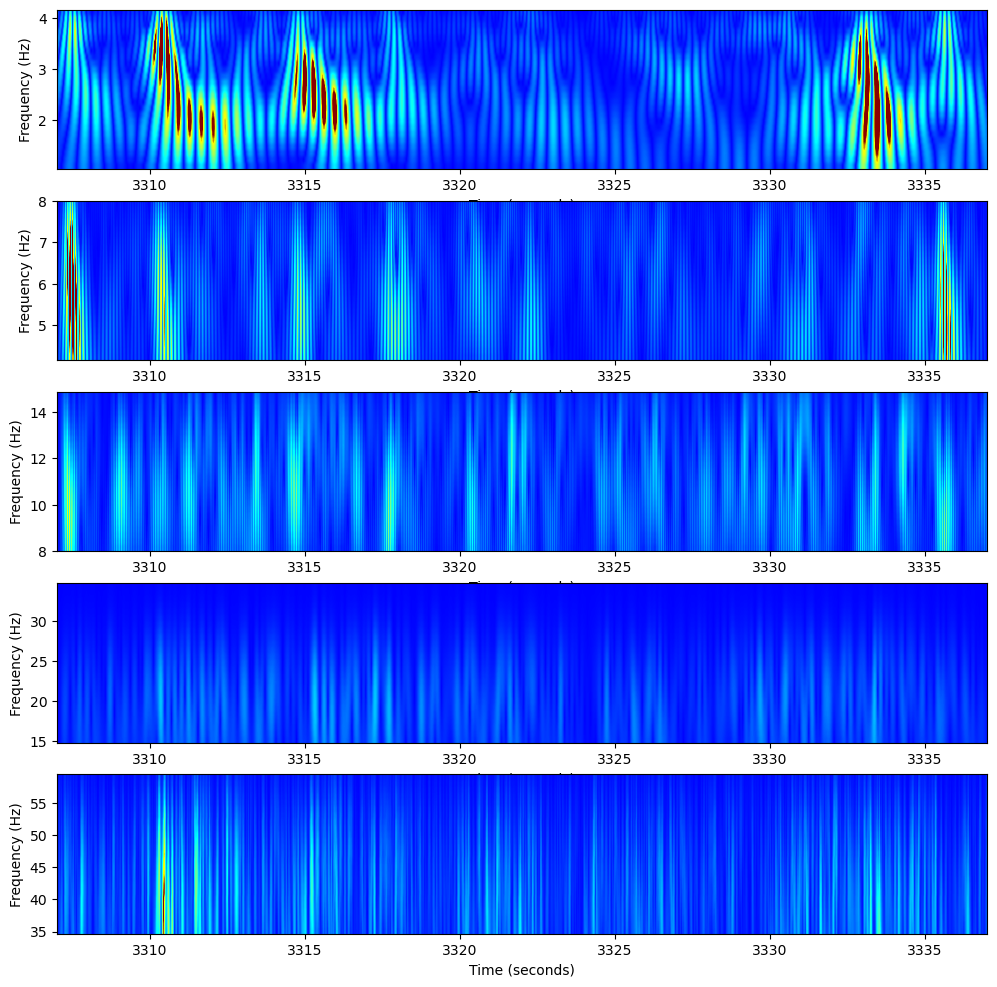

<Figure size 1500x700 with 0 Axes>

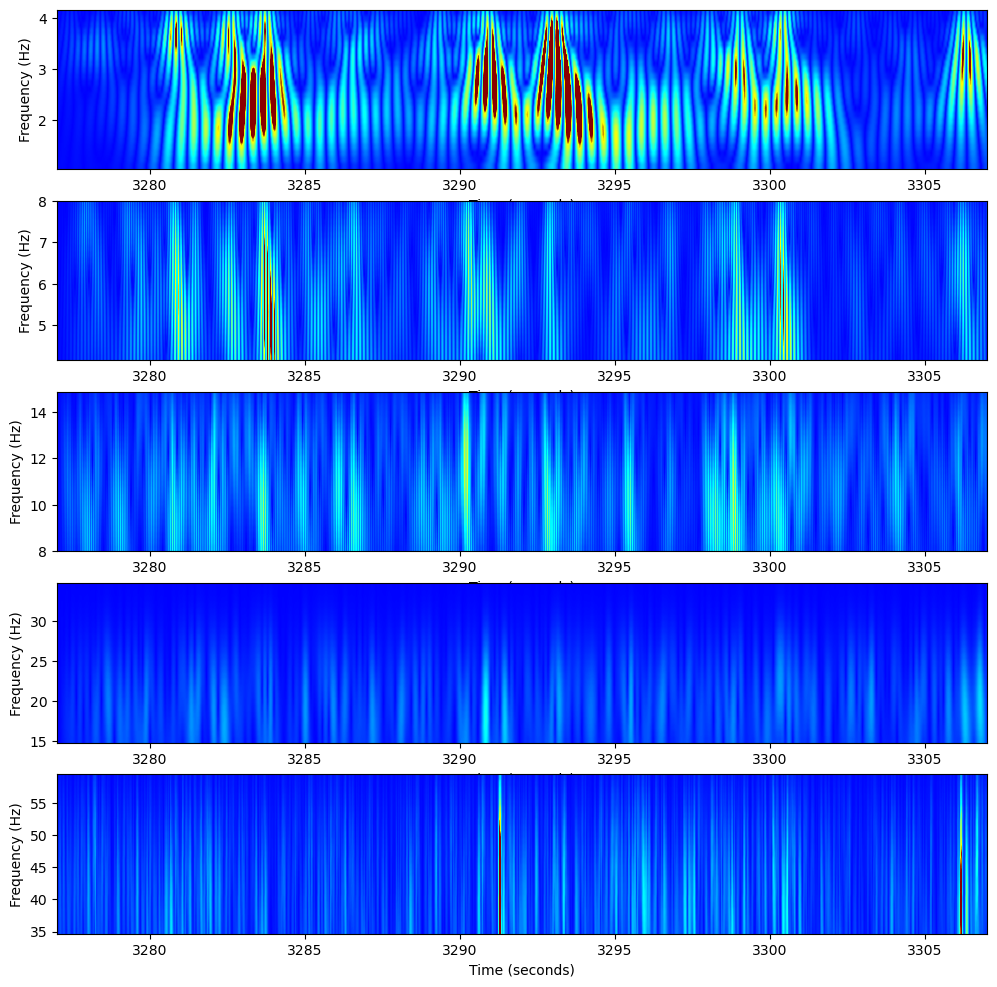

<Figure size 1500x700 with 0 Axes>

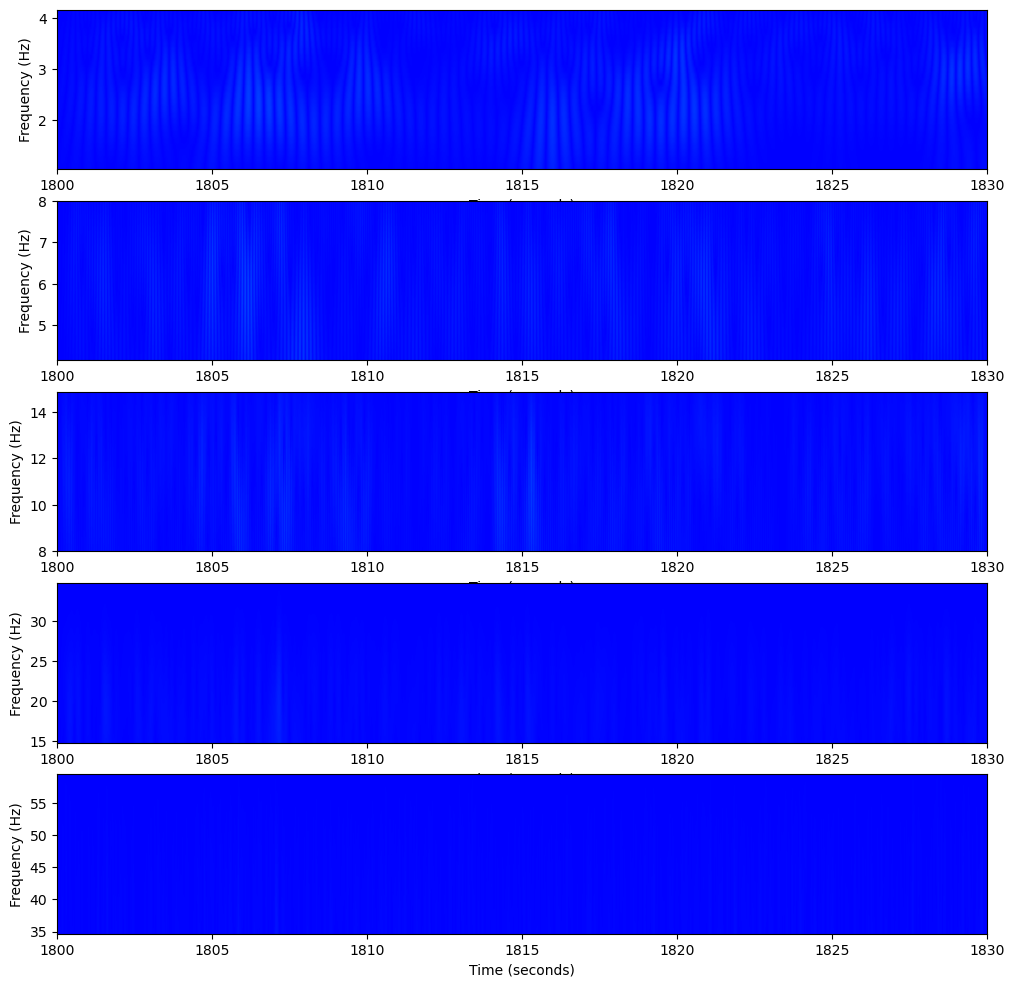

<Figure size 1500x700 with 0 Axes>

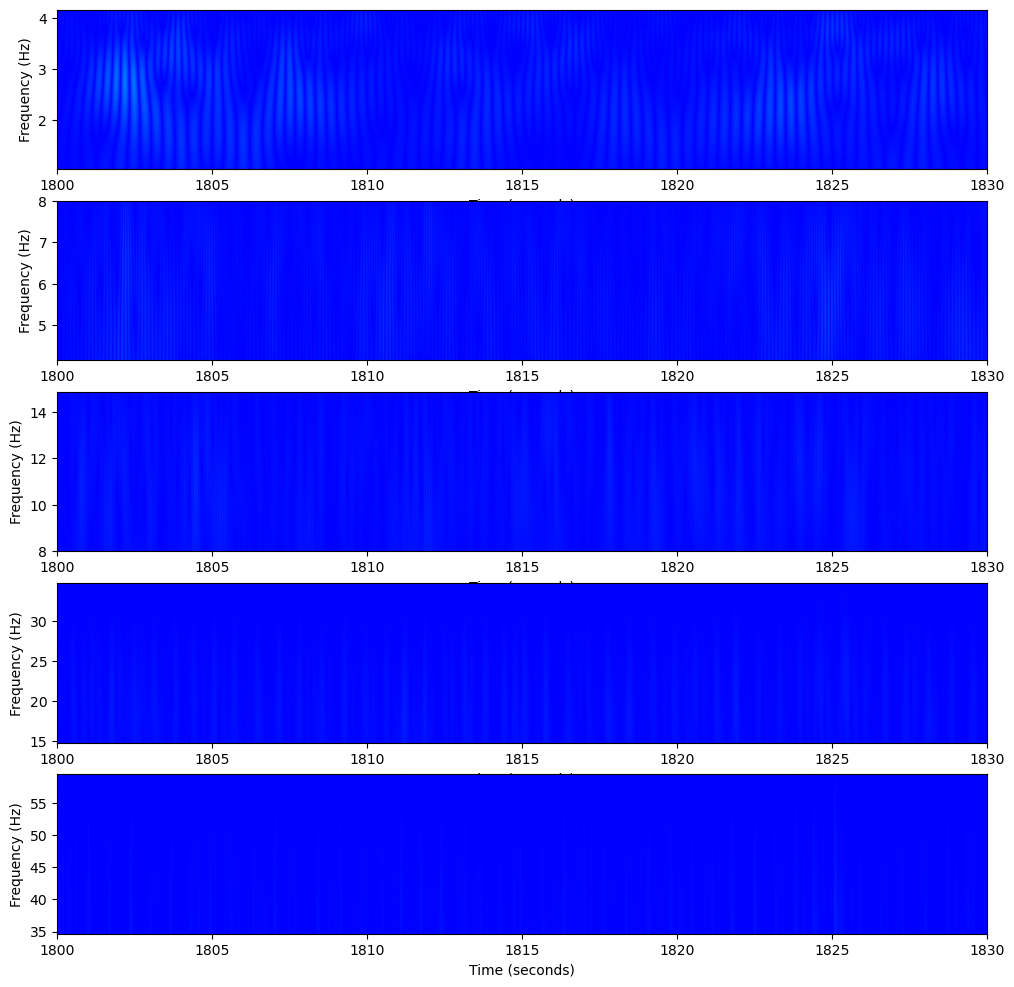

<Figure size 1500x700 with 0 Axes>

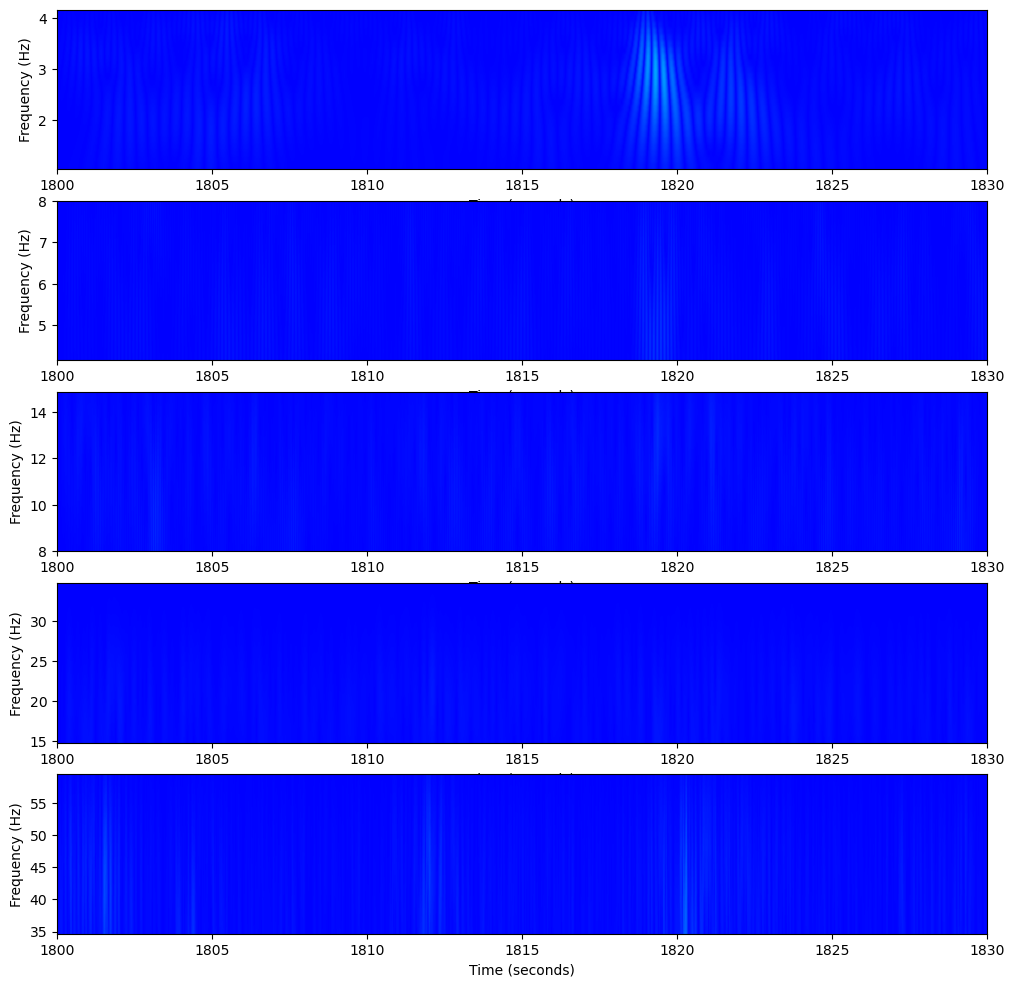

<Figure size 1500x700 with 0 Axes>

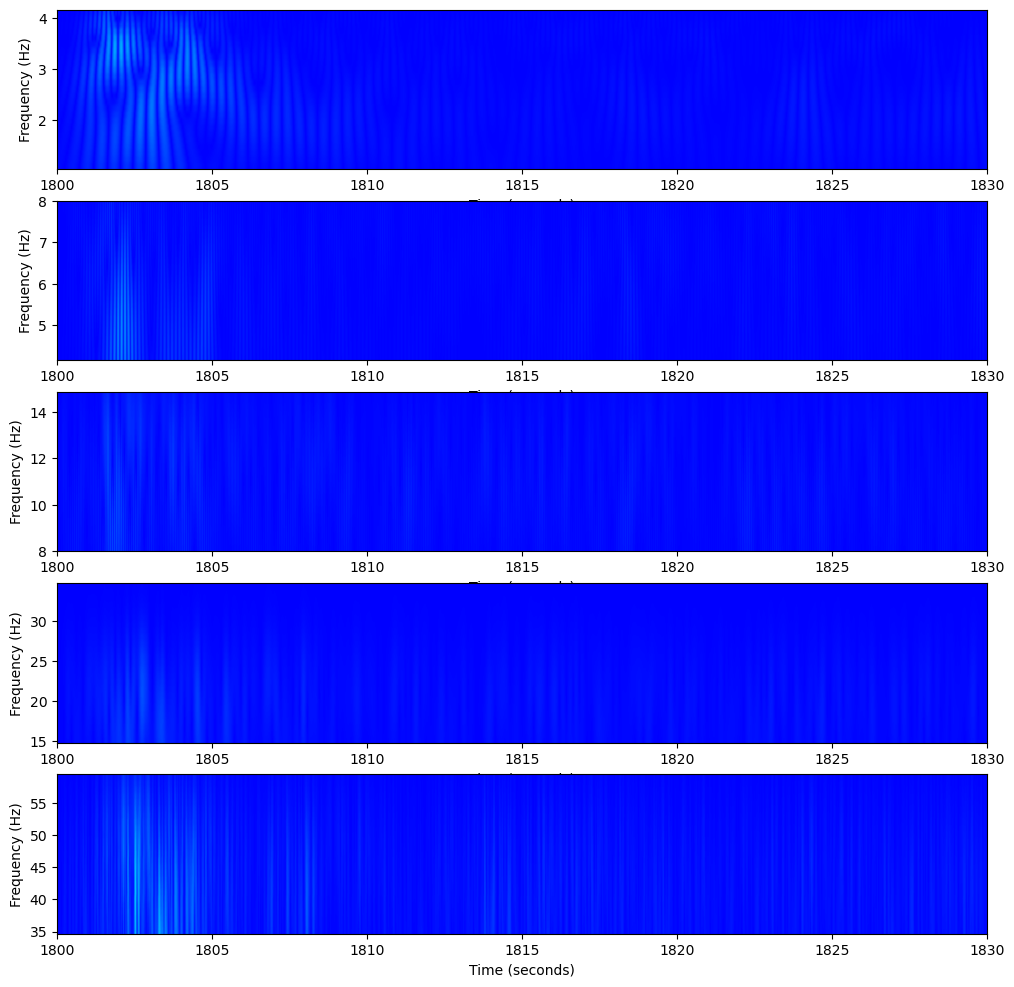

<Figure size 1500x700 with 0 Axes>

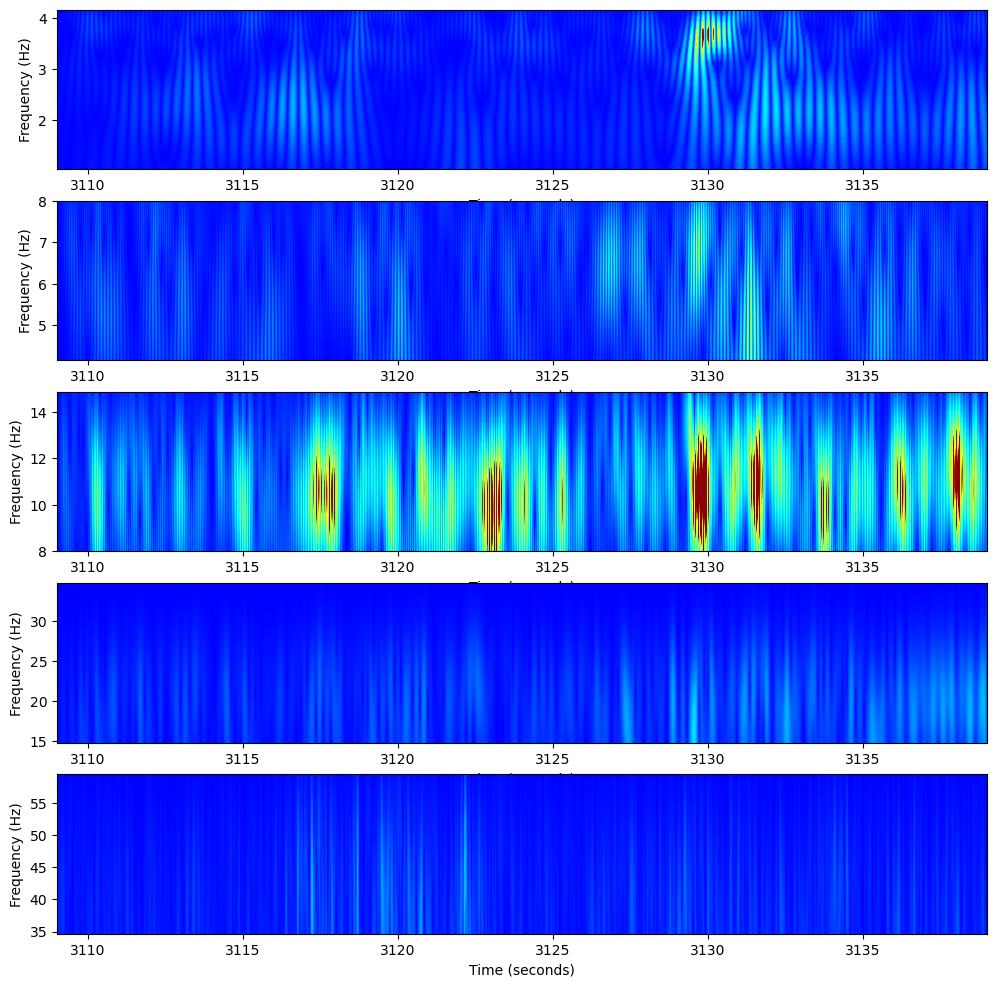

<Figure size 1500x700 with 0 Axes>

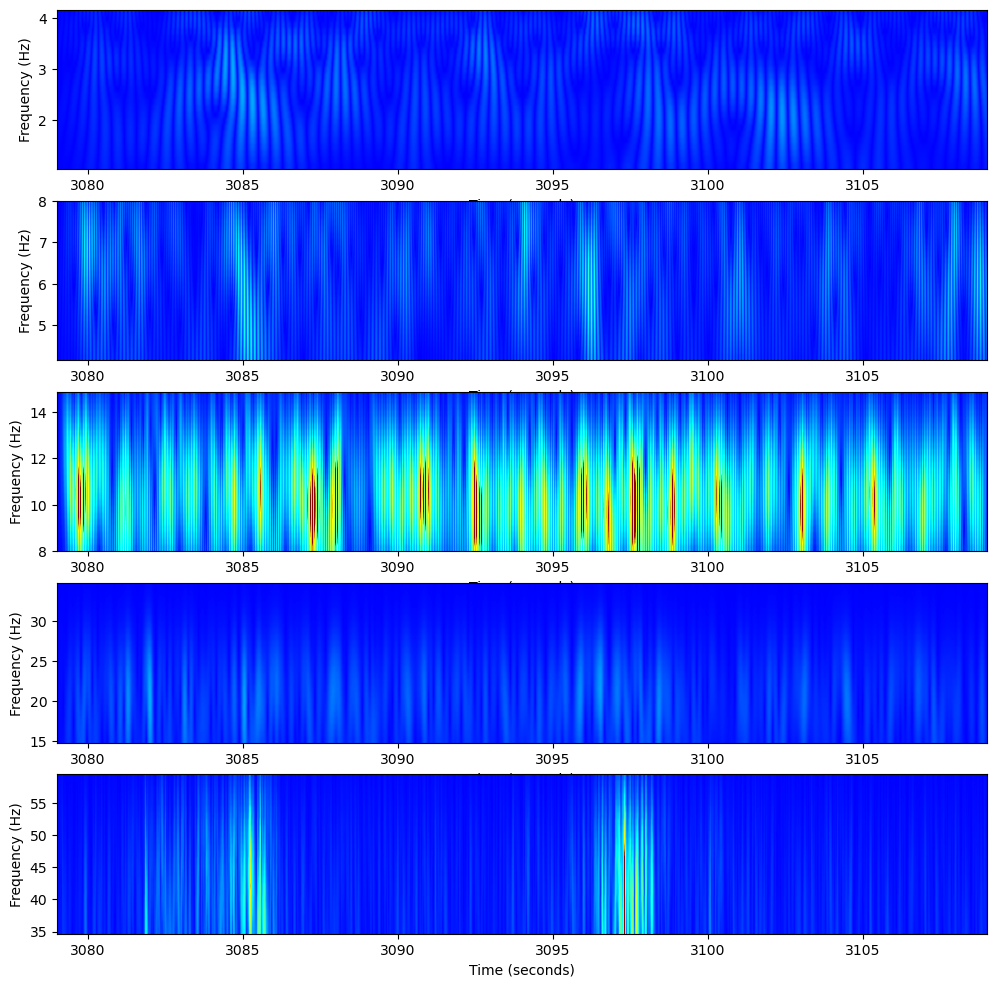

<Figure size 1500x700 with 0 Axes>

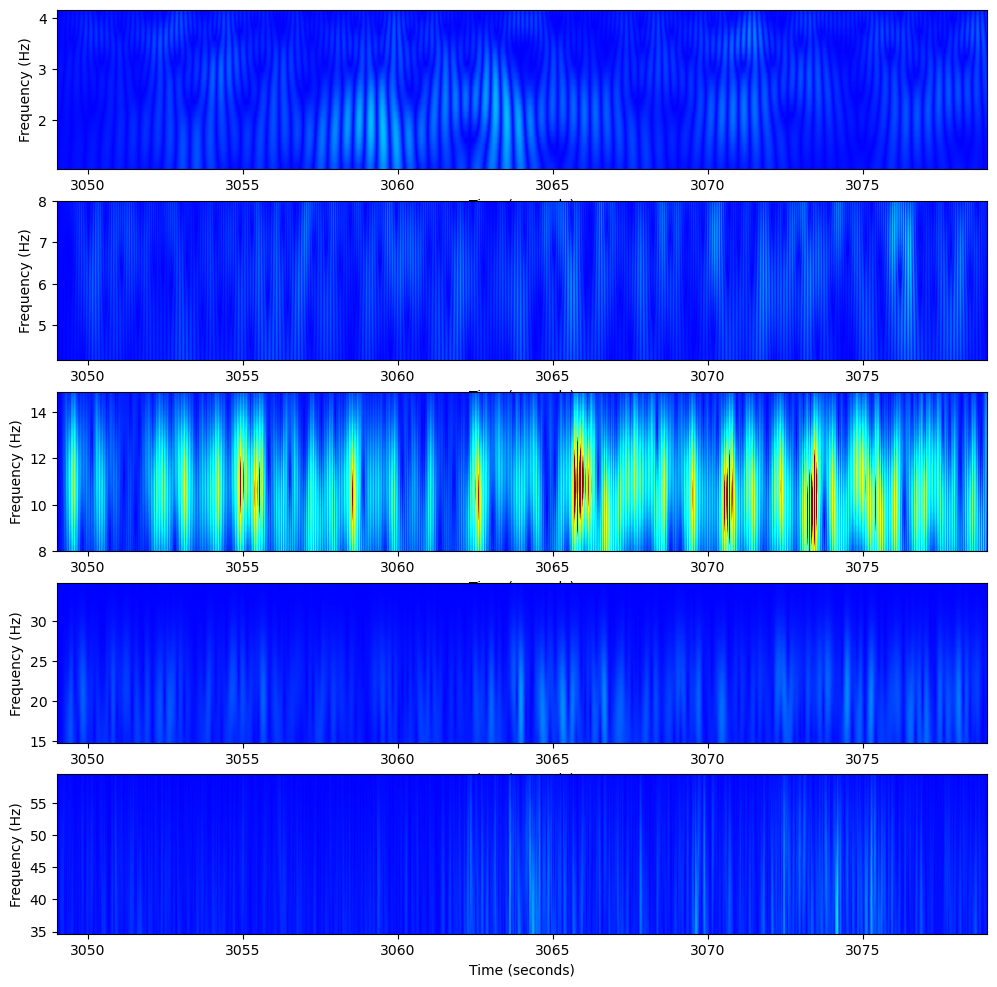

<Figure size 1500x700 with 0 Axes>

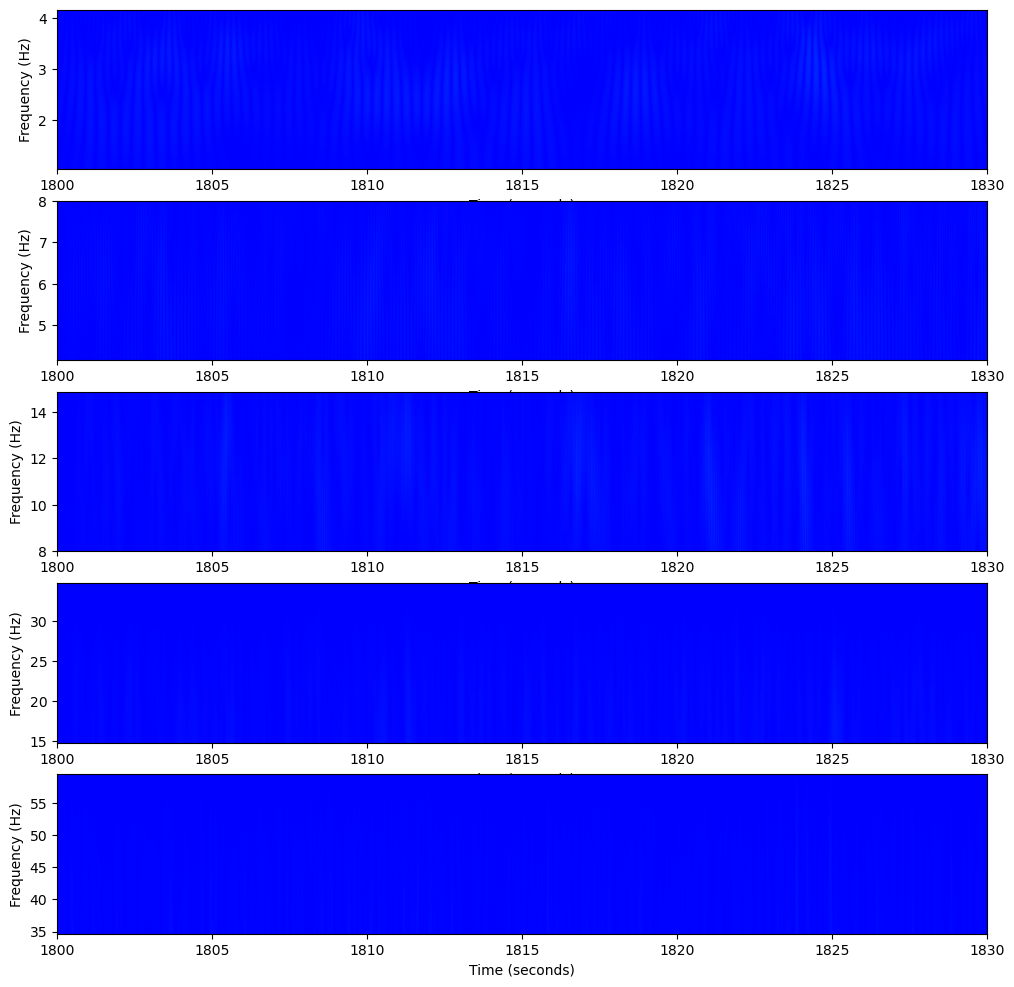

<Figure size 1500x700 with 0 Axes>

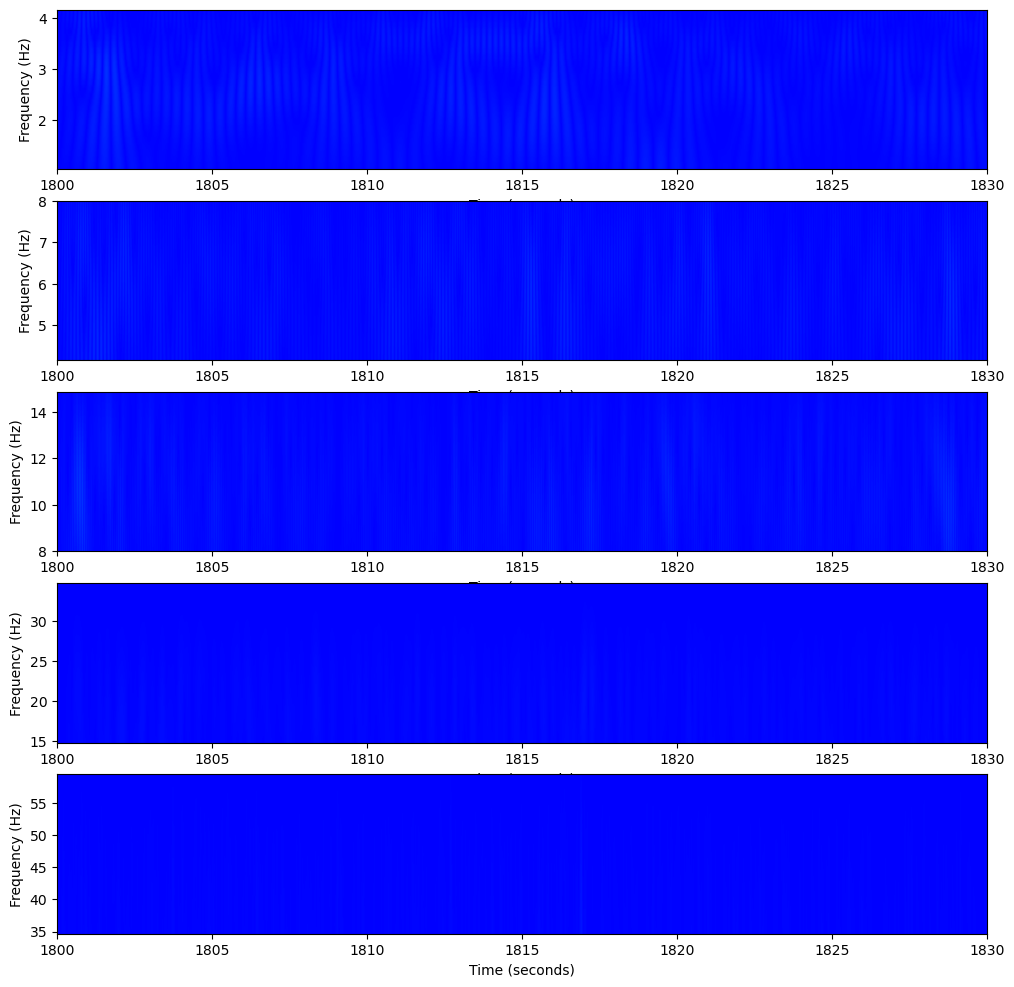

<Figure size 1500x700 with 0 Axes>

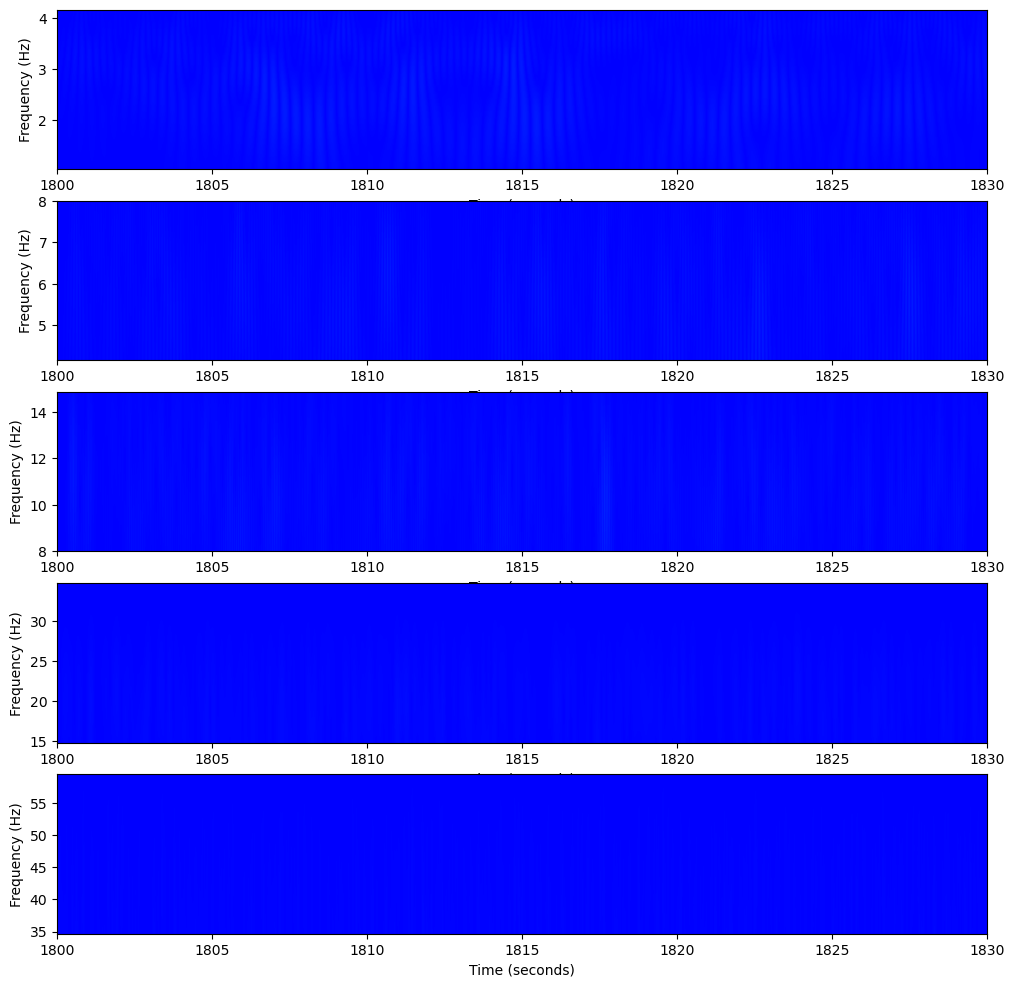

<Figure size 1500x700 with 0 Axes>

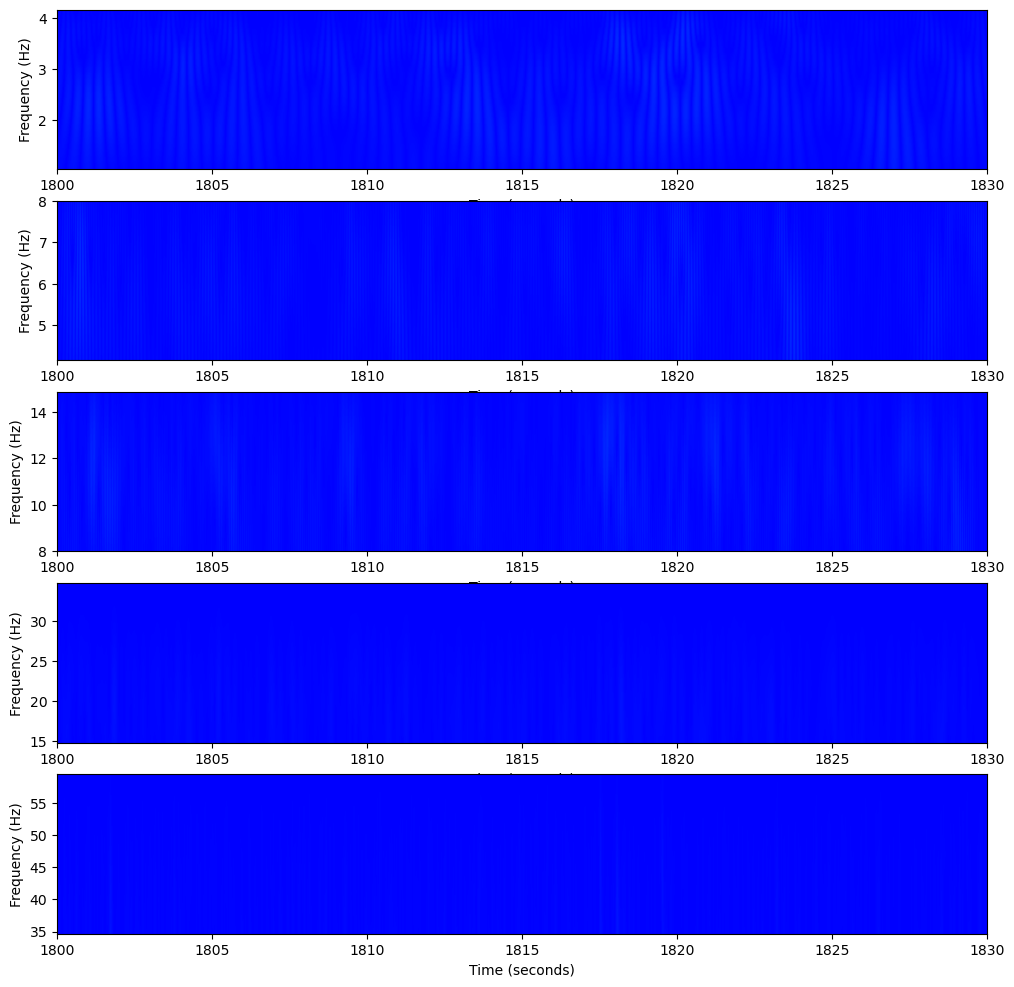

<Figure size 1500x700 with 0 Axes>

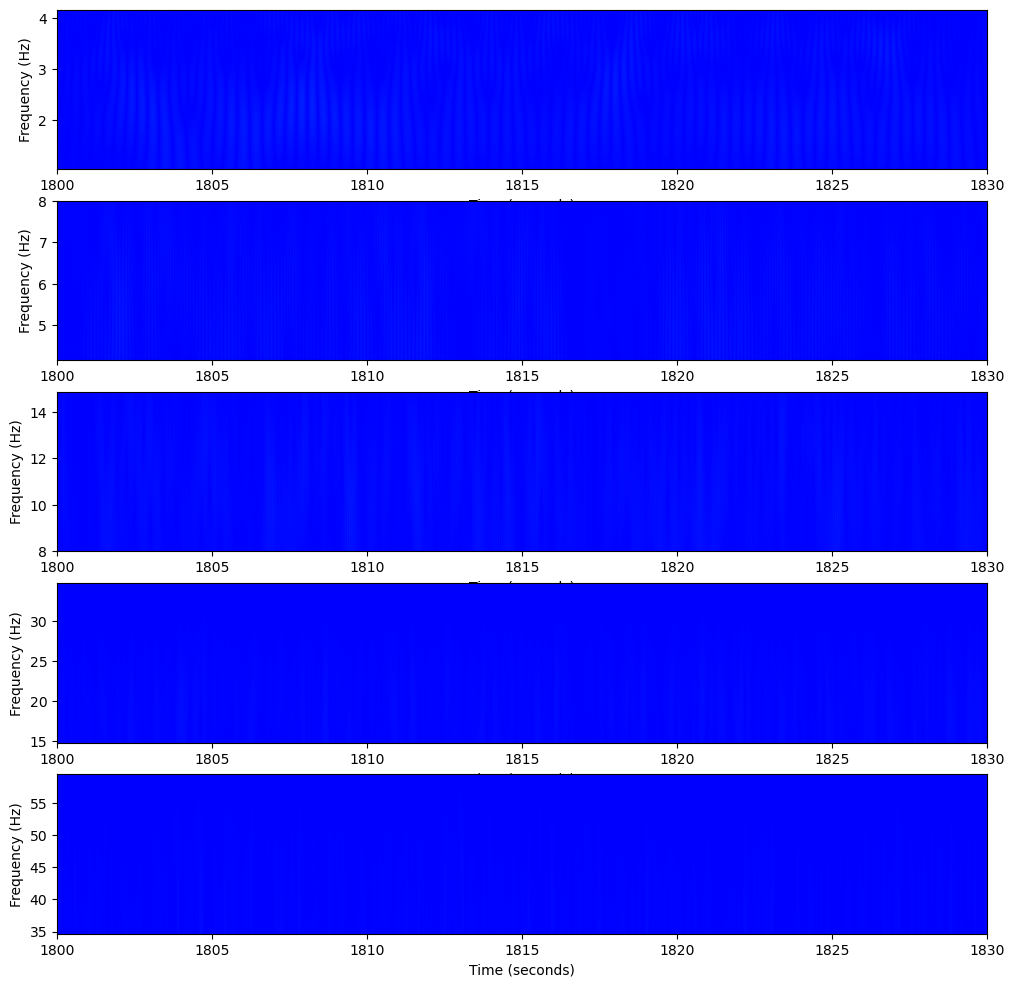

<Figure size 1500x700 with 0 Axes>

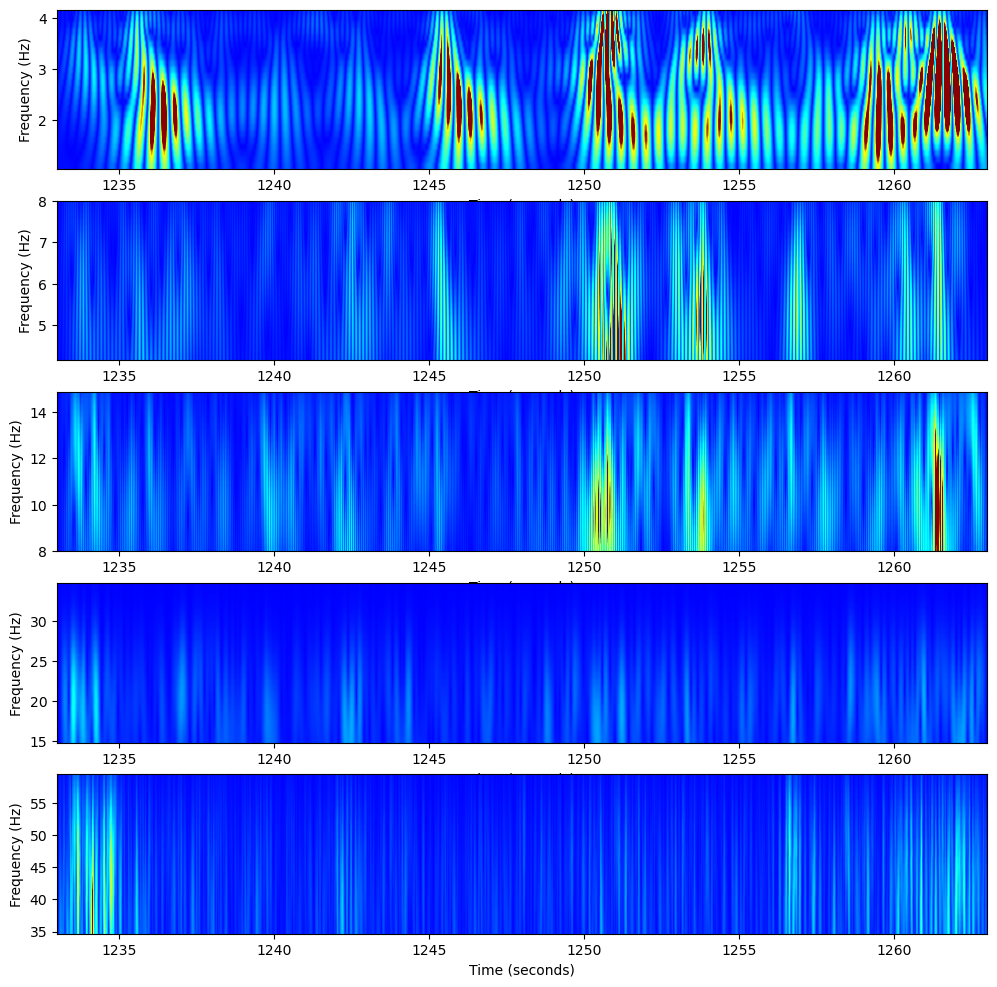

<Figure size 1500x700 with 0 Axes>

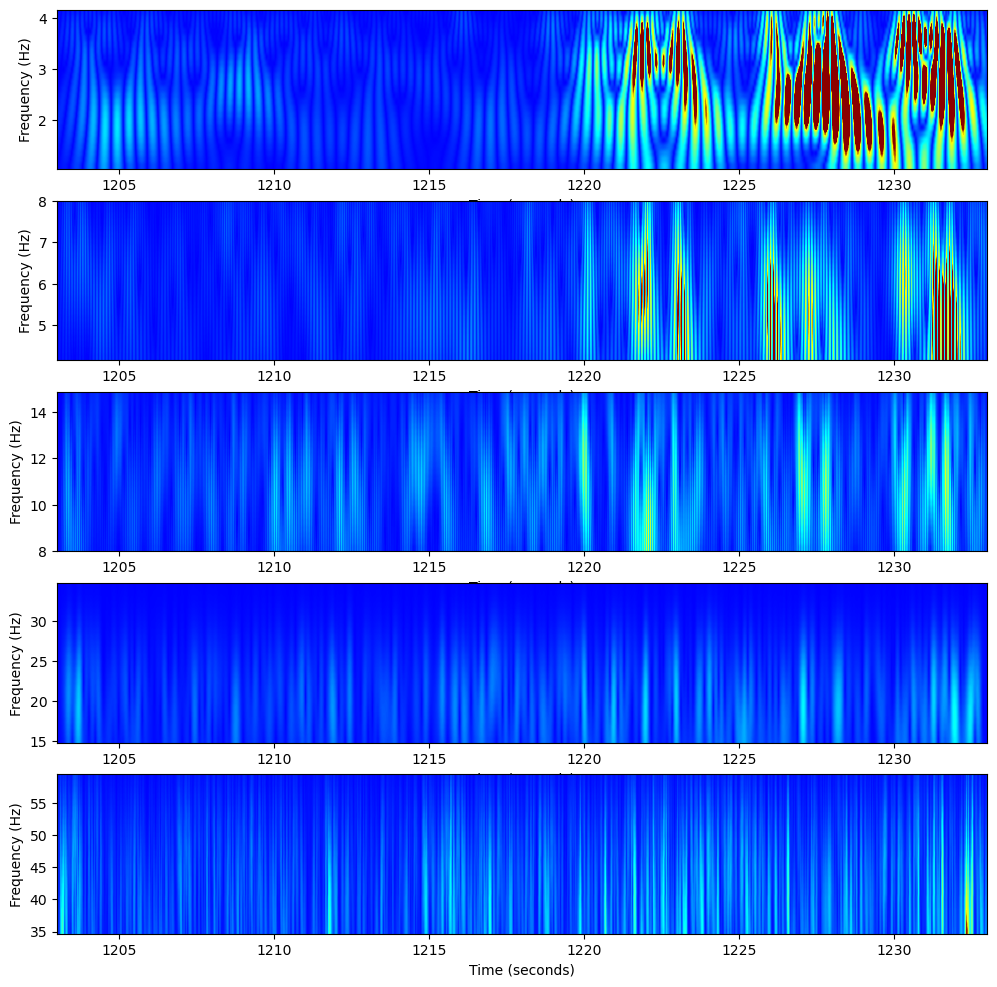

<Figure size 1500x700 with 0 Axes>

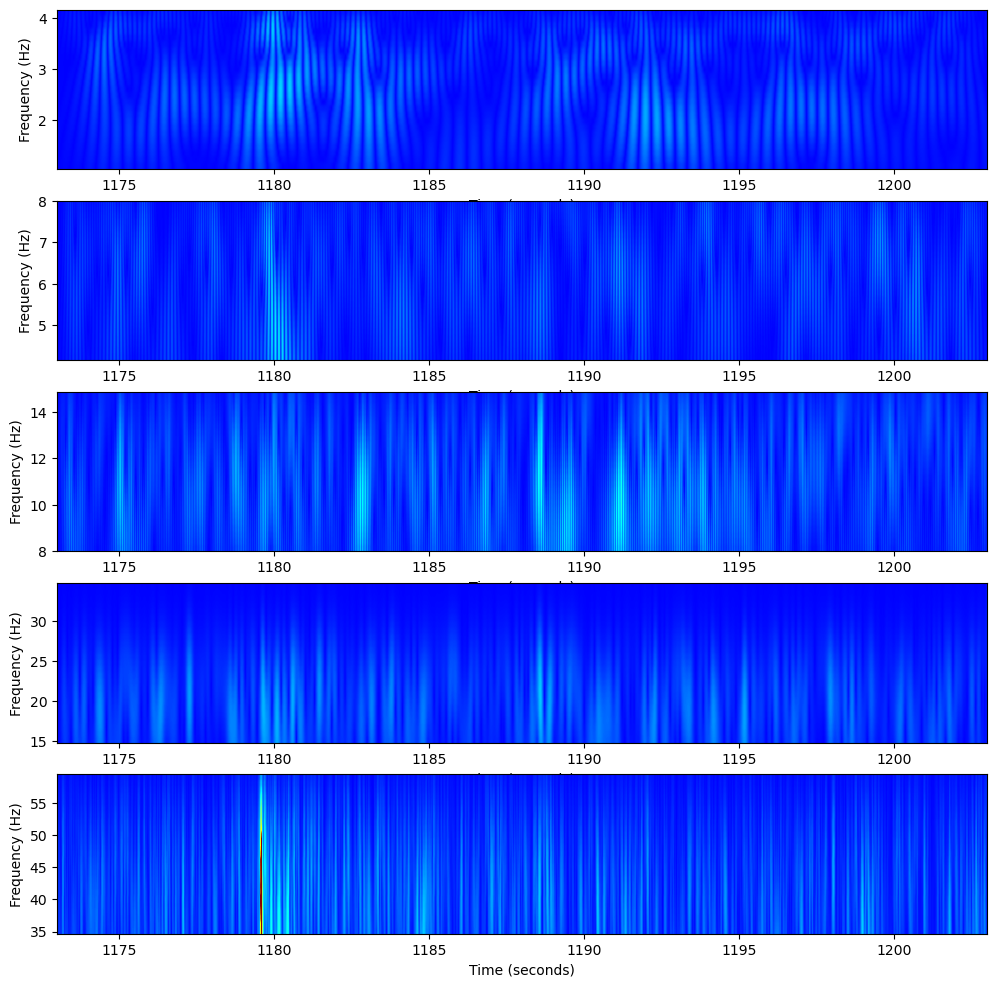

<Figure size 1500x700 with 0 Axes>

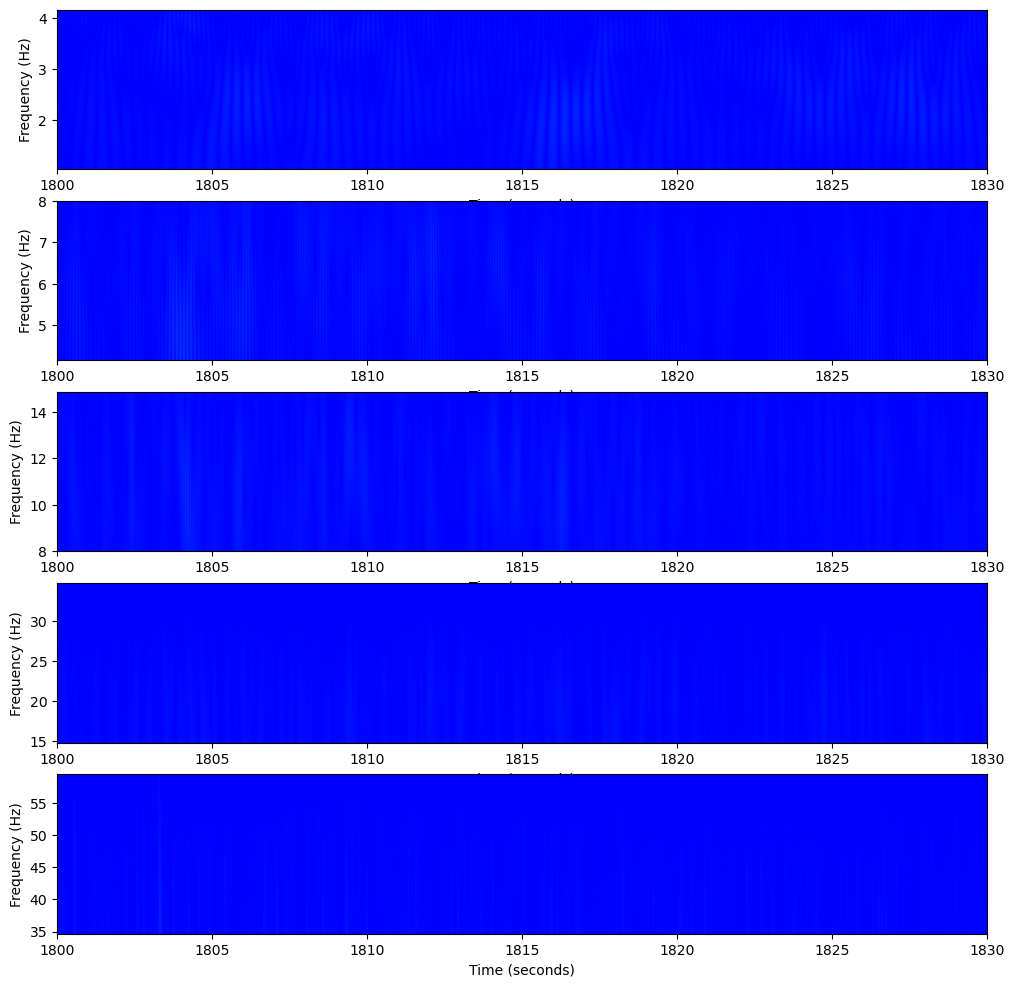

<Figure size 1500x700 with 0 Axes>

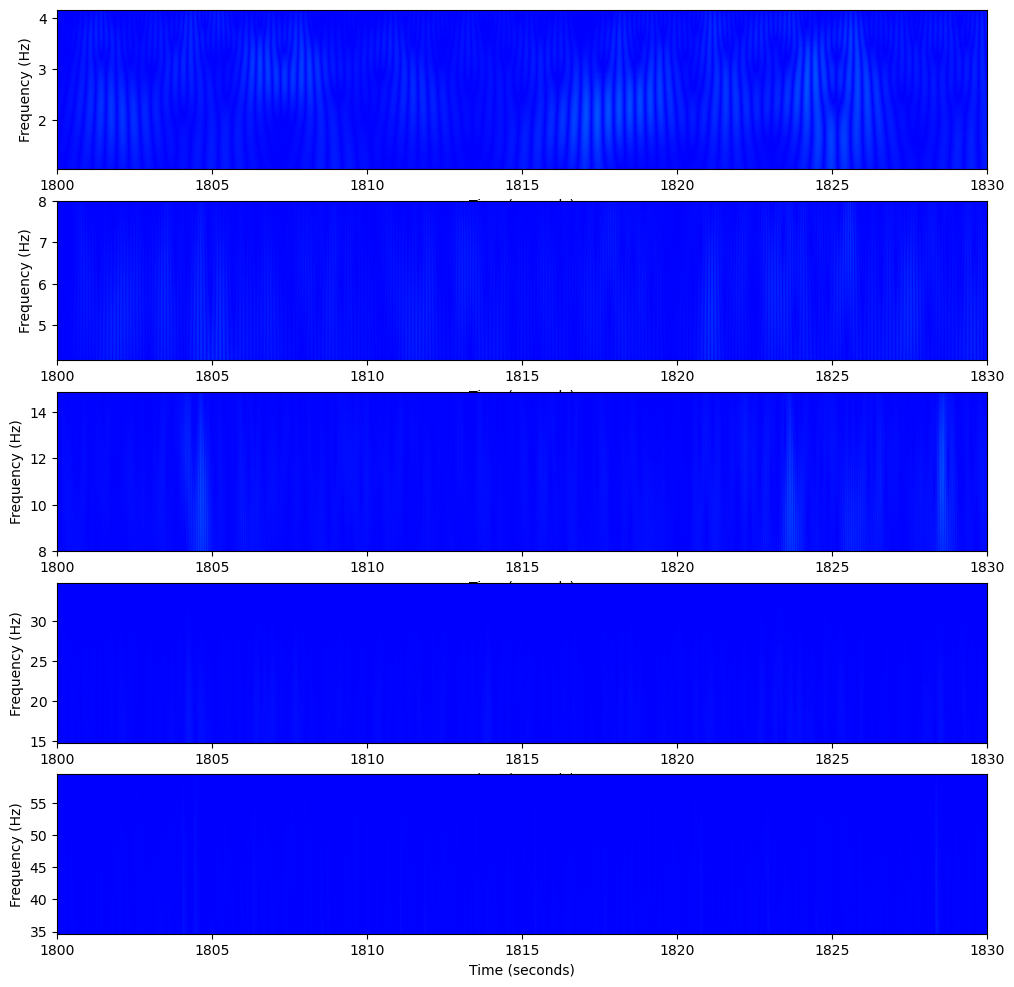

<Figure size 1500x700 with 0 Axes>

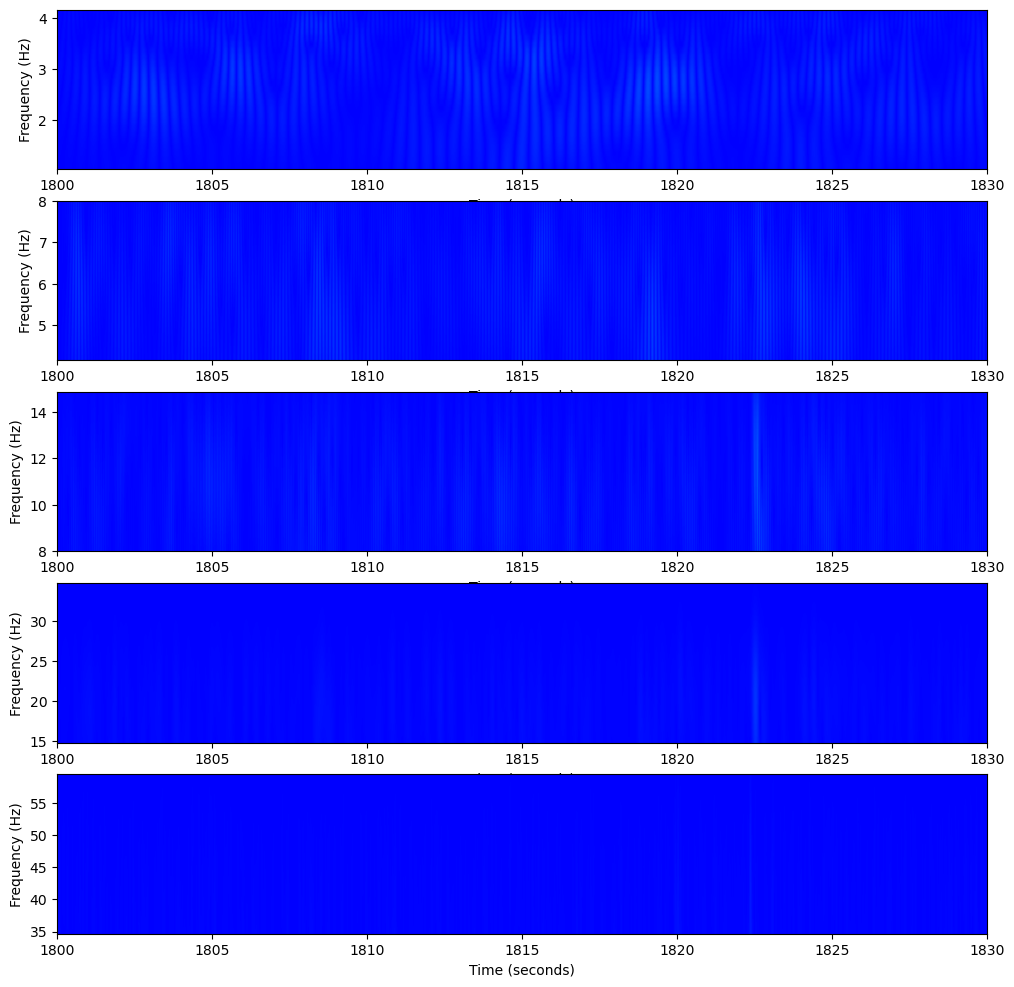

In [36]:
for edf_file in edf_files_list:
    edf_file_path = f'./datasets/{edf_file["file_name"]}'
    signals, labels = read_edf(edf_file_path)

    if len(edf_file['seizure_start']) != 0:
        flag = 1
        seizure_times = [(30, '30_sec_before'), (30, '60_sec_before'), (30, '90_sec_before')]
        number = 1
        for seiz_time in range(len(edf_file['seizure_start'])):
            seizure_st = edf_file['seizure_start'][seiz_time]
            seizure_en = edf_file['seizure_end'][seiz_time]
            for time_offset, time_label in seizure_times:
                time_window_start = seizure_st - time_offset
                time_window_end = seizure_st  # Окно в 30 секунд
                seizure_st = seizure_st - 30
                time_window_start_samples = time_window_start * sampling_rate
                time_window_end_samples = time_window_end * sampling_rate
                signal_s = np.delete(signals, [len(signals) - 1], axis=0)
                time = np.arange(time_window_start, time_window_end, 1 / sampling_rate)

                # Усреднение сигналов
                avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
                for i in range(len(signals) - 1):
                    avg_signal += signal_s[i, time_window_start_samples:time_window_end_samples]
                avg_signal /= len(signals)

                # Применение фильтра Баттерворта
                filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)
                filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time,plot_signal=False)

                # Определяем директорию и путь для сохранения изображения
                save_dir = './seizure'
                os.makedirs(save_dir, exist_ok=True)

                # Сохранение изображения
                image_path = f"{edf_file['file_name']}_{time_label}_{number}_wavelet.png"
                save_wavelet_transform(
                    filtered_mean,
                    image_path,
                    save_dir,
                    time_window_start,
                    time_window_end,
                    sampling_rate,
                    time_label
                )
                number+=1
    else:
        # Обработка для записей без приступа (Healthy)
        flag = 0
        #приступов нет, поэтому выбираем любое значение времени для выгрузки ЭЭГ
        time_window_start = int(signals.shape[1] / sampling_rate / 2)
        time_label = 30 #ширина окна для выгрузки данных
        time_window_end = time_window_start + time_label

        time_window_start_samples = time_window_start * sampling_rate
        time_window_end_samples = time_window_end * sampling_rate

        signals = np.delete(signals, [len(signals) - 1], axis=0)
        time = np.arange(time_window_start, time_window_end, 1 / sampling_rate)

        # Усреднение сигналов
        avg_signal = np.zeros(time_window_end_samples - time_window_start_samples)
        for i in range(len(signals) - 1):
            # Проходим по всем каналам
            avg_signal += signals[i, time_window_start_samples:time_window_end_samples]
            avg_signal /= len(signals)  # Среднее значение по всем каналам

        # Фильр Баттерворта
        filtered_data = butter_bandpass_filter(avg_signal, sampling_rate, plot_signal=False)

        # Удаление среднего скользящим окном
        filtered_mean = mean_delete(filtered_data, window_count, sampling_rate,time, plot_signal=False)

        # Определяем директорию и путь для сохранения изображения
        save_dir = './healthy'
        os.makedirs(save_dir, exist_ok=True)
        image_path = f"{edf_file['file_name']}_{time_label}_wavelet.png"

        # Сохранение изображения
        save_wavelet_transform(
            filtered_mean,
            image_path,
            save_dir,
            time_window_start,
            time_window_end,
            sampling_rate,
            time_label
        )

### Задание 4
Спроектируйте сверточную нейронную сеть для обучения классификации ЭЭГ на те данные, которые имеют и не имеют приступ.


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Reshape, TimeDistributed, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.utils import class_weight, shuffle

import tensorflow as tf

In [39]:
# Функция для загрузки изображений
def load_images(target_size):
    images = []
    labels = []
    for class_dir in ['healthy', 'seizure']:  # Подкаталоги классов
        class_path = f'./{class_dir}'
        label = 0 if class_dir == 'healthy' else 1  # Классы кодируются как 0 или 1
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            img = tf.image.resize(img, target_size)  # Изменение размеров изображения
            images.append(img)
            labels.append(label)

    plt.show()

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [40]:
def display_samples(X, y, num_samples, dataset_name='Dataset'):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.imshow(X[i,:,:,:])
        plt.title(f'Label: {np.argmax(y[i])}')
        plt.axis('off')

    plt.suptitle(f'Sample images from {dataset_name}')
    plt.show()

In [41]:
X, y = load_images((512, 512),)

In [42]:
X, y = shuffle(X, y, random_state=24)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [43]:
# Преобразование меток в категориальный формат (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [44]:
y_train = y_train.astype(np.float64)
X_train = X_train.astype(np.float64)

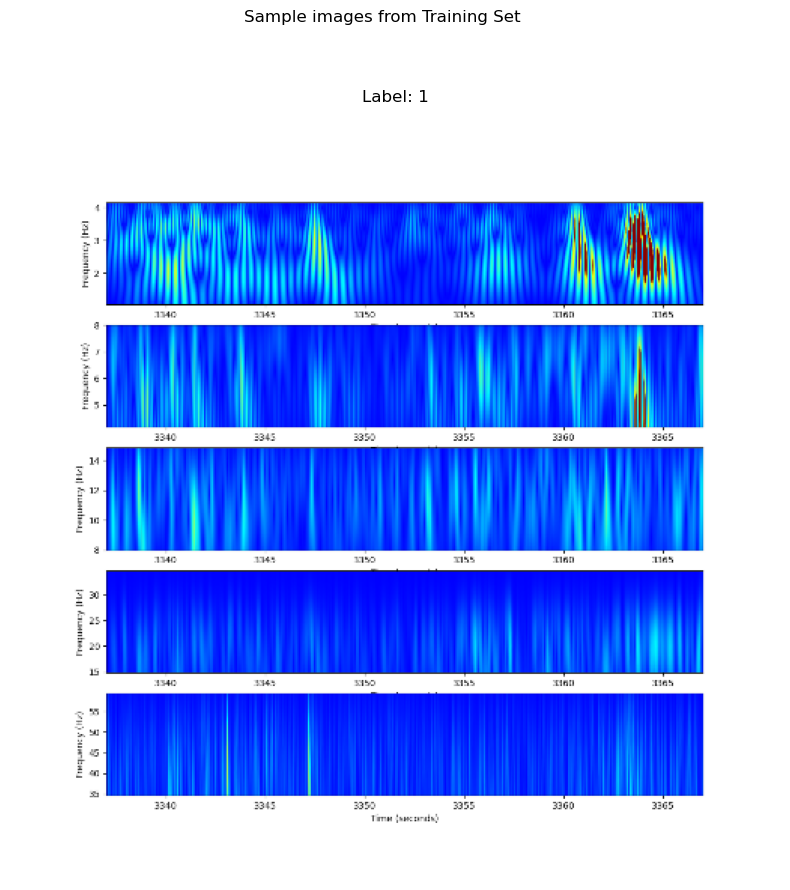

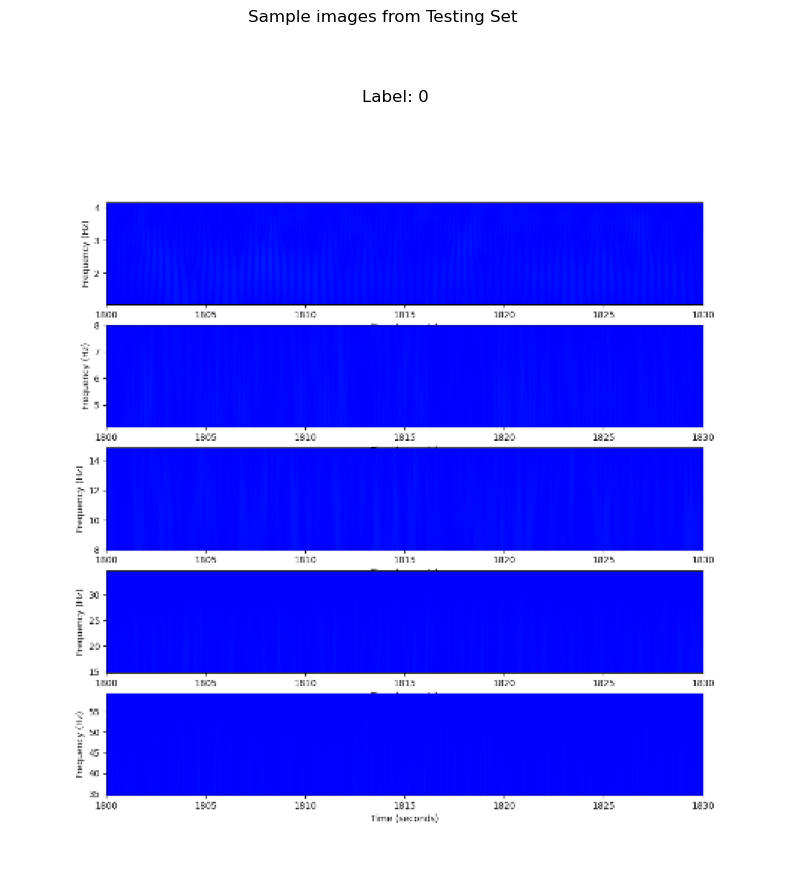

In [45]:
display_samples(X_train, y_train, num_samples=3, dataset_name='Training Set')
display_samples(X_test, y_test, num_samples=3, dataset_name='Testing Set')

In [46]:
def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # Cверточные слои
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Полносвязный слой
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.05)))

    # Выходной слой для двух классов
    model.add(Dense(2, activation='sigmoid'))  # Для классификации на 2 класса

    # Компиляция модели
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [47]:
input_shape = (512, 512, 4)  # Изображения 64x64 с 3 каналами (RGB)
model = create_cnn_lstm_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,580,322 (120.47 MB)

 Trainable params: 31,580,322 (120.47 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# Преобразование меток обратно из one-hot encoding в одномерный массив меток
y_train_classes = np.argmax(y_train, axis=1)

# Вычисление весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_classes), y=y_train_classes)

# Преобразование class_weights в словарь
class_weights_dict = dict(enumerate(class_weights))

checkpoint = ModelCheckpoint(
    'best_weights.keras',    # Имя файла для сохранения весов
    monitor='val_accuracy',  # Метрика для отслеживания
    save_best_only=True,     # Сохранять только если улучшилась метрика
    mode='max',              # "max" для максимизации метрики
    verbose=1
)

# Обучение модели с указанием весов классов
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=8,
    validation_split=0.2,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 569ms/step - accuracy: 0.8757 - loss: 28.3317 - val_accuracy: 0.1667 - val_loss: 17.3707
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step - accuracy: 0.3111 - loss: 14.7711 - val_accuracy: 0.1667 - val_loss: 14.1008
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 445ms/step - accuracy: 0.3363 - loss: 14.2768 - val_accuracy: 0.1667 - val_loss: 15.4272
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step - accuracy: 0.3424 - loss: 14.3382 - val_accuracy: 0.8333 - val_loss: 13.1542
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 442ms/step - accuracy: 0.8601 - loss: 13.1399 - val_accuracy: 0.1667 - val_loss: 12.6437


In [49]:
y_test__pred = model.predict(X_test)
y_test__pred = np.argmax(y_test__pred, axis=1)

y_test__true = np.argmax(y_test, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


In [50]:
print('Classification Report:')
print(classification_report(y_test__true, y_test__pred))
print('Accuracy:', accuracy_score(y_test__true, y_test__pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.00      0.00      0.00         3

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8

Accuracy: 0.625


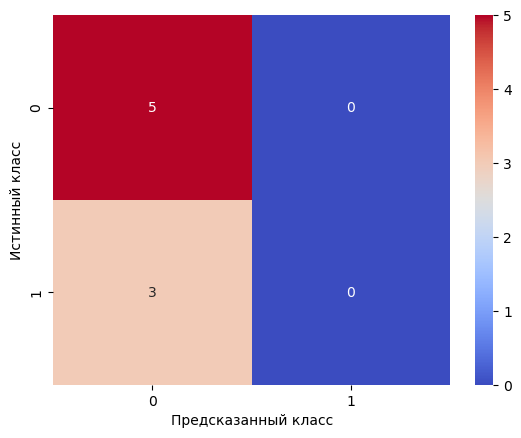

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [51]:
conf_matrix = confusion_matrix(y_test__true, y_test__pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
class_names = ['Содержащий приступ', 'Не содержащий приступ']

plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

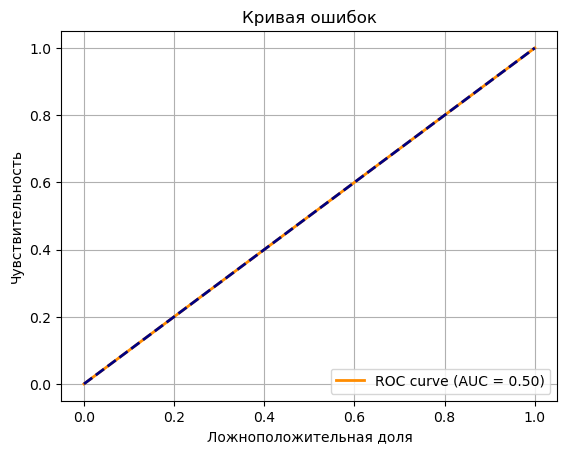

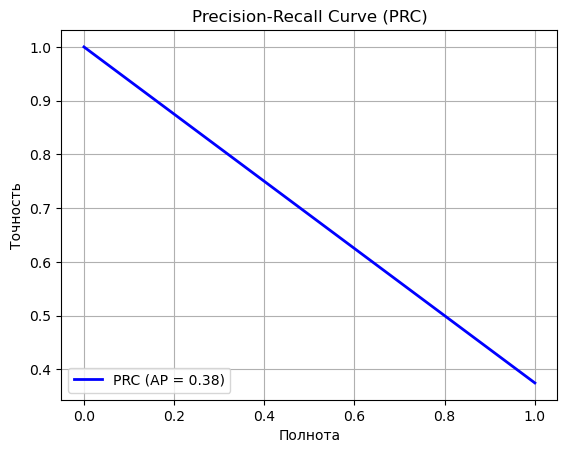

In [52]:
fpr, tpr, _ = roc_curve(y_test__true, y_test__pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Диагональная линия
plt.xlabel('Ложноположительная доля')
plt.ylabel('Чувствительность')
plt.title('Кривая ошибок')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Построение Precision-Recall кривой
precision, recall, _ = precision_recall_curve(y_test__true, y_test__pred)
average_precision = average_precision_score(y_test__true, y_test__pred)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PRC (AP = {average_precision:.2f})')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc='lower left')
plt.grid()
plt.show()

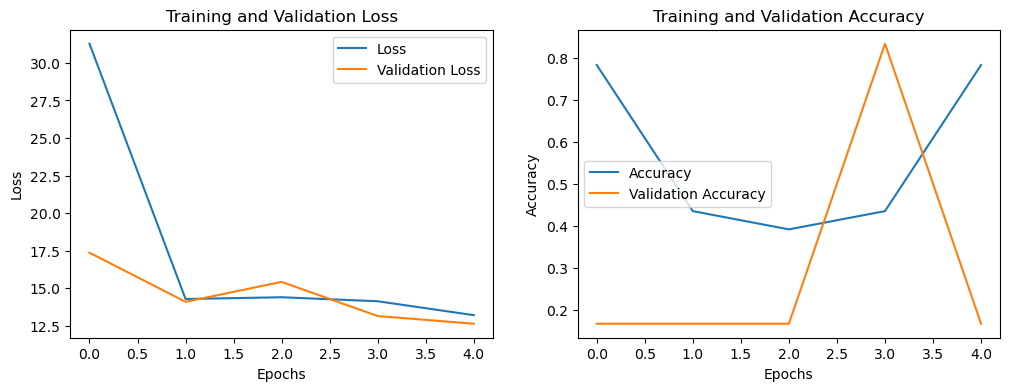

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.close()

### Задание 5
Сохраните модель обученной сети и проверьте ее работу.


In [55]:
# Сохранение модели
model.save('cnn_eeg_epilepsy_model.h5')

In [56]:
# Сохранение весов
model.save_weights('model_weights.weights.h5')

In [57]:
loaded_model = tf.keras.models.load_model('cnn_eeg_epilepsy_model.h5')

In [58]:
y_test__pred_from_loaded = loaded_model.predict(X_test)
y_test__pred_from_loaded = np.argmax(y_test__pred_from_loaded, axis=1)

accuracy_score(y_test__true, y_test__pred_from_loaded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


0.625

In [59]:
import mne

In [60]:
data = mne.io.read_raw_edf('eeg1.edf', preload=True)

Extracting EDF parameters from C:\Users\dvm10\Desktop\Platforms\Task5\eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1790207  =      0.000 ...  6992.996 secs...


In [61]:
eeg_data, eeg_times = data.get_data(return_times=True)

In [62]:
f'число отчетов во временном ряду: {len(eeg_times)}'

'число отчетов во временном ряду: 1790208'

In [63]:
# устанавливаем диапазон для обработки данных
t_index_begin = np.where(eeg_times > 1 * 318 - 300)[0][0]
t_index_end = np.where(eeg_times > 1 * 452 + 300)[0][0]
t = eeg_times[t_index_begin:t_index_end]

# значение времени = конец сигнала
T = t[-1] - t[0]
# число элементов во временном ряду
N = len(t)

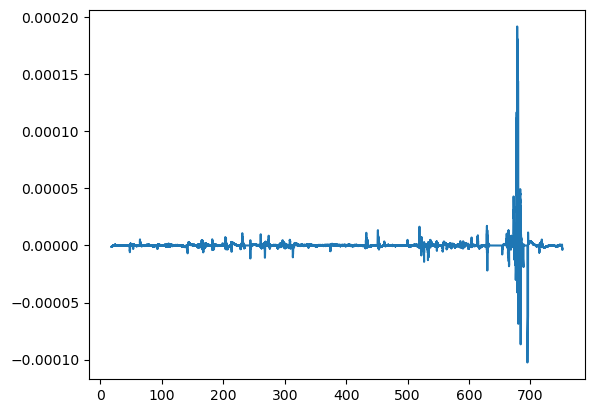

In [64]:
y=[]

for i in range(len(eeg_data)-2):
    y =+ eeg_data[i, t_index_begin:t_index_end]

y = y / (len(eeg_data) - 1)
plt.plot(t, y)
plt.show()

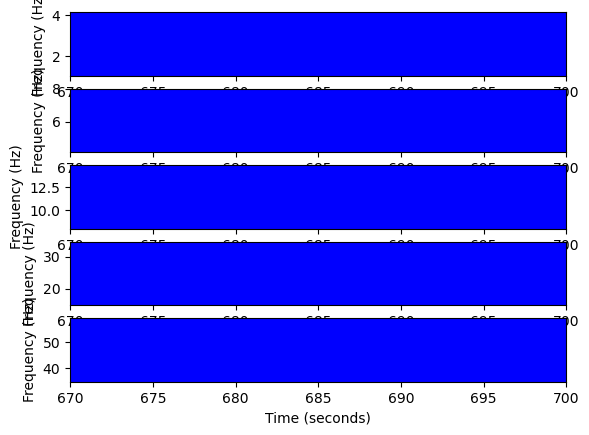

'./testEDFepi\\testEDFepi_wavelet.png_30_wavelet.png'

In [65]:
seizure_st = 670
sampling_rate = 256
signals = y
time_label = 30

time_window_start = seizure_st
seizure_st = seizure_st + 30
time_window_end = seizure_st

time = np.arange(time_window_start, time_window_end, 1 / sampling_rate)

# Применение фильтра Баттерворта
filtered_data = butter_bandpass_filter(y, sampling_rate, plot_signal=False)
# filtered_mean = mean_delete(filtered_data, window_count, sampling_rate, time, plot_signal=False)
filtered_mean = filtered_data

# Определяем директорию и путь для сохранения изображения
save_dir = './testEDFepi'
os.makedirs(save_dir, exist_ok=True)

# Сохранение изображения
image_path = 'testEDFepi_wavelet.png'
save_wavelet_transform(
    filtered_mean,
    image_path,
    save_dir,
    time_window_start,
    time_window_end,
    sampling_rate,
    time_label
)

In [66]:
images = []
class_path = './testEDFepi'
for img_name in os.listdir(class_path):
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)
    img = tf.image.resize(img, (512, 512))
    images.append(img)

plt.show()

images = np.array(images)

In [67]:
y_image = loaded_model.predict(images)
np.argmax(y_image, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


array([0], dtype=int64)

### Задание 6
Попробуйте проделать действия с использованием AutoML и сравните ратоту.

# AUTOKERAS

In [69]:
import autokeras as ak

In [70]:
import mlflow

In [71]:
clf = ak.ImageClassifier(overwrite=True, max_trials=1)

In [107]:
X, y = load_images((512, 512),)
X, y = shuffle(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)

y_train_classes = y_train  # Просто используйте как есть
y_test_classes = y_test

In [108]:
clf.fit(X_train, y_train_classes, epochs=5)

Trial 1 Complete [00h 00m 18s]
val_loss: 0.0

Best val_loss So Far: 0.0
Total elapsed time: 00h 00m 18s
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.3368 - loss: 7.6850
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7655 - loss: 66.3130
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9081 - loss: 1.0684
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.2345 - loss: 29.1562
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.2345 - loss: 10.6774


In [110]:
best_model = clf.export_model()
best_model.layers

[<InputLayer name=input_layer, built=True>,
 <CastToFloat32 name=cast_to_float32, built=True>,
 <Normalization name=normalization, built=True>,
 <Conv2D name=conv2d, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Dropout name=dropout, built=True>,
 <Flatten name=flatten, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense, built=True>,
 <Activation name=classification_head_1, built=True>]

In [111]:
y_train__predicted = clf.predict(X_train)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/stepWARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D7CF27ACA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


In [112]:
y_test__predicted = clf.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [113]:
clf.evaluate(X_test, y_test_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 1.0000 - loss: 4.7160e-11


[4.715997037330055e-11, 1.0]

In [114]:
print('Classification Report Test Data:')
print(classification_report(y_test_classes, y_test__predicted))
print('Accuracy:', accuracy_score(y_test_classes, y_test__predicted))

Classification Report Test Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Accuracy: 1.0


In [115]:
print('Classification Report Train Data:')
print(classification_report(y_train_classes, y_train__predicted))
print('Accuracy:', accuracy_score(y_train_classes, y_train__predicted))

Classification Report Train Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         8

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33

Accuracy: 1.0


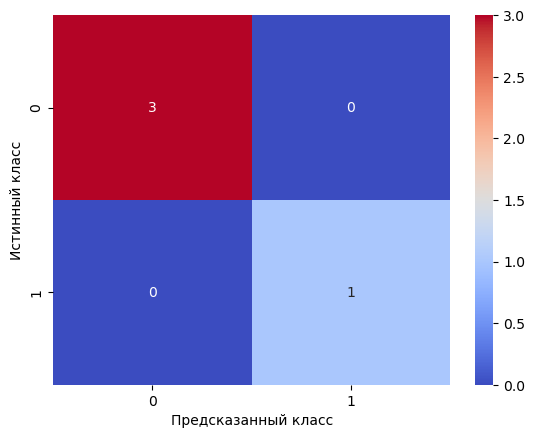

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [116]:
conf_matrix = confusion_matrix(y_test_classes, y_test__predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
class_names = ['Содержащий приступ', 'Не содержащий приступ']

plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

In [138]:
import subprocess
from threading import Thread

def start_mlflow():
    subprocess.run(["mlflow", "ui", "--host", "0.0.0.0", "--port", "5000"])

Thread(target=start_mlflow, daemon=True).start()

In [140]:
mlflow.set_tracking_uri(uri='http://localhost:5000')
mlflow.set_experiment('Task5')

2025/04/10 22:47:29 INFO mlflow.tracking.fluent: Experiment with name 'Task5' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/906824766134576255', creation_time=1744314449519, experiment_id='906824766134576255', last_update_time=1744314449519, lifecycle_stage='active', name='Task5', tags={}>

In [142]:
with mlflow.start_run(run_name='AUTOKERAS'):
    mlflow.log_params(
        {
            'overwrite': True,
            'max_trials': 1,
            'epochs': 5
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy для обучающих данных': accuracy_score(y_train_classes, y_train__predicted),
            'Accuracy для тестовых данных': accuracy_score(y_test_classes, y_test__predicted),
        }
    )
    mlflow.log_artifact('./image_classifier/best_pipeline')

🏃 View run AUTOKERAS at: http://localhost:5000/#/experiments/906824766134576255/runs/3acd4b639045477685d15162f09e9f5a
🧪 View experiment at: http://localhost:5000/#/experiments/906824766134576255


# LAMA

In [165]:
import pandas as pd
from lightautoml.tasks import Task
from lightautoml.automl.presets.image_presets import TabularCVAutoML

In [167]:
healthy_images = []
dir_name = './healthy'
for path in os.listdir(dir_name):
    healthy_images.append(f'{dir_name}/{path}')

In [171]:
seizure_images = []
dir_name = './seizure' 
for path in os.listdir(dir_name):
    seizure_images.append(f'{dir_name}/{path}')

In [173]:
data = pd.DataFrame(
    {
        'path': healthy_images + seizure_images,
        'label': [0] * len(healthy_images) + [1] * len(seizure_images)
    }
)
data

path  label
0   ./healthy/chb22_01.edf_30_wavelet.png_30_wavel...      0
1   ./healthy/chb22_02.edf_30_wavelet.png_30_wavel...      0
2   ./healthy/chb22_03.edf_30_wavelet.png_30_wavel...      0
3   ./healthy/chb22_04.edf_30_wavelet.png_30_wavel...      0
4   ./healthy/chb22_05.edf_30_wavelet.png_30_wavel...      0
5   ./healthy/chb22_06.edf_30_wavelet.png_30_wavel...      0
6   ./healthy/chb22_07.edf_30_wavelet.png_30_wavel...      0
7   ./healthy/chb22_08.edf_30_wavelet.png_30_wavel...      0
8   ./healthy/chb22_09.edf_30_wavelet.png_30_wavel...      0
9   ./healthy/chb22_10.edf_30_wavelet.png_30_wavel...      0
10  ./healthy/chb22_11.edf_30_wavelet.png_30_wavel...      0
11  ./healthy/chb22_15.edf_30_wavelet.png_30_wavel...      0
12  ./healthy/chb22_16.edf_30_wavelet.png_30_wavel...      0
13  ./healthy/chb22_17.edf_30_wavelet.png_30_wavel...      0
14  ./healthy/chb22_18.edf_30_wavelet.png_30_wavel...      0
15  ./healthy/chb22_19.edf_30_wavelet.png_30_wavel...      0
16  ./healthy/chb22_21.edf_30_wavelet.png_30_wavel...      0
17  ./healthy/chb22_22.edf_30_wavelet.png_30_wavel...      0
18  ./healthy/chb22_23.edf_30_wavelet.png_30_wavel...      0
19  ./healthy/chb22_24.edf_30_wavelet.png_30_wavel...      0
20  ./healthy/chb22_26.edf_30_wavelet.png_30_wavel...      0
21  ./healthy/chb22_27.edf_30_wavelet.png_30_wavel...      0
22  ./healthy/chb22_28.edf_30_wavelet.png_30_wavel...      0
23  ./healthy/chb22_29.edf_30_wavelet.png_30_wavel...      0
24  ./healthy/chb22_30.edf_30_wavelet.png_30_wavel...      0
25  ./healthy/chb22_51.edf_30_wavelet.png_30_wavel...      0
26  ./healthy/chb22_54.edf_30_wavelet.png_30_wavel...      0
27  ./healthy/chb22_77.edf_30_wavelet.png_30_wavel...      0
28  ./seizure/chb22_20.edf_30_sec_before_1_wavelet...      1
29  ./seizure/chb22_20.edf_60_sec_before_2_wavelet...      1
30  ./seizure/chb22_20.edf_90_sec_before_3_wavelet...      1
31  ./seizure/chb22_25.edf_30_sec_before_1_wavelet...      1
32  ./seizure/chb22_25.edf_60_sec_before_2_wavelet...      1
33  ./seizure/chb22_25.edf_90_sec_before_3_wavelet...      1
34  ./seizure/chb22_38.edf_30_sec_before_1_wavelet...      1
35  ./seizure/chb22_38.edf_60_sec_before_2_wavelet...      1
36  ./seizure/chb22_38.edf_90_sec_before_3_wavelet...      1

In [175]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

In [177]:
automl = TabularCVAutoML(
    task = Task('binary'),
    timeout=5 * 3600,
    cpu_limit = 2,
    reader_params = {'cv': 5, 'random_state': 42}
)

In [179]:
predictions = automl.fit_predict(train_data, roles={'target': 'label', 'path': ['path']}, verbose=3)

[22:57:49] Stdout logging level is INFO3.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO3.


[22:57:49] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[22:57:49] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[22:57:49] - time: 18000.00 seconds


INFO:lightautoml.automl.presets.base:- time: 18000.00 seconds


[22:57:49] - CPU: 2 cores


INFO:lightautoml.automl.presets.base:- CPU: 2 cores


[22:57:49] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[22:57:49] Train data shape: (29, 2)



INFO:lightautoml.reader.base:Train data shape: (29, 2)



[22:57:49] Layer 1 train process start. Time left 17999.98 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 17999.98 secs


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.93s/it]

[22:58:36] Feature path transformed



INFO3:lightautoml.transformers.image:Feature path transformed


[22:58:36] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 768}


[22:58:36] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[22:58:36] Linear model: C = 1e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 1.0


[22:58:36] Linear model: C = 5e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 1.0


[22:58:36] Linear model: C = 0.0001 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 1.0


[22:58:36] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[22:58:36] Linear model: C = 1e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 1.0


[22:58:36] Linear model: C = 5e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 1.0


[22:58:36] Linear model: C = 0.0001 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 1.0


[22:58:36] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[22:58:36] Linear model: C = 1e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 1.0


[22:58:36] Linear model: C = 5e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 1.0


[22:58:36] Linear model: C = 0.0001 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 1.0


[22:58:36] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[22:58:36] Linear model: C = 1e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 1.0


[22:58:36] Linear model: C = 5e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 1.0


[22:58:36] Linear model: C = 0.0001 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 1.0


[22:58:36] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[22:58:37] Linear model: C = 1e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 1.0


[22:58:37] Linear model: C = 5e-05 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 1.0


[22:58:37] Linear model: C = 0.0001 score = 1.0


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 1.0


[22:58:37] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6363636363636364


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6363636363636364


[22:58:37] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[22:58:37] Time left 17952.38 secs



INFO:lightautoml.automl.base:Time left 17952.38 secs



[22:58:40] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[22:58:40] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[22:58:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[22:58:40] [100]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.5


[22:58:40] [200]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.5


[22:58:40] Early stopping, best iteration is:
[1]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's auc: 0.5


[22:58:40] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[22:58:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[22:58:40] [100]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.5


[22:58:40] [200]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.5


[22:58:40] Early stopping, best iteration is:
[1]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's auc: 0.5


[22:58:40] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[22:58:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[22:58:40] [100]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.5


[22:58:40] [200]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.5


[22:58:40] Early stopping, best iteration is:
[1]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's auc: 0.5


[22:58:40] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[22:58:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[22:58:40] [100]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.5


[22:58:40] [200]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.5


[22:58:40] Early stopping, best iteration is:
[1]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's auc: 0.5


[22:58:40] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[22:58:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[22:58:40] [100]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.5


[22:58:40] [200]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.5


[22:58:40] Early stopping, best iteration is:
[1]	valid's auc: 0.5


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's auc: 0.5


[22:58:40] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.38961038961038963


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.38961038961038963


[22:58:40] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[22:58:40] Time left 17948.58 secs



INFO:lightautoml.automl.base:Time left 17948.58 secs



[22:58:40] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[22:58:40] Blending: optimization starts with equal weights. Score = 0.6298701


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.6298701


[22:58:40] Blending: iteration 0: score = 0.6363636, weights = [0.6352549  0.36474508]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.6363636, weights = [0.6352549  0.36474508]


[22:58:40] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[22:58:40] Blending: best score = 0.6363636, best weights = [0.6352549  0.36474508]


INFO:lightautoml.automl.blend:Blending: best score = 0.6363636, best weights = [0.6352549  0.36474508]


[22:58:40] Automl preset training completed in 51.47 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 51.47 seconds



[22:58:40] Model description:
Final prediction for new objects (level 0) = 
	 0.63525 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.36475 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.63525 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.36475 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 



In [180]:
test_predictions = automl.predict(test_data).data

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]

[22:58:46] Feature path transformed



INFO3:lightautoml.transformers.image:Feature path transformed


In [181]:
for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

In [185]:
predictions_data = predictions.data
for i in range(len(predictions_data)):
    if predictions_data[i] > 0.5:
        predictions_data[i] = 1
    else:
        predictions_data[i] = 0

In [187]:
print('Classification Report Test Data:')
print(classification_report(test_data['label'], test_predictions))
print('Accuracy:', accuracy_score(test_data['label'], test_predictions))

Classification Report Test Data:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       0.00      0.00      0.00         2

    accuracy                           0.75         8
   macro avg       0.38      0.50      0.43         8
weighted avg       0.56      0.75      0.64         8

Accuracy: 0.75


In [189]:
print('Classification Report Train Data:')
print(classification_report(train_data['label'], predictions_data))
print('Accuracy:', accuracy_score(train_data['label'], predictions_data))

Classification Report Train Data:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        22
           1       0.00      0.00      0.00         7

    accuracy                           0.76        29
   macro avg       0.38      0.50      0.43        29
weighted avg       0.58      0.76      0.65        29

Accuracy: 0.7586206896551724


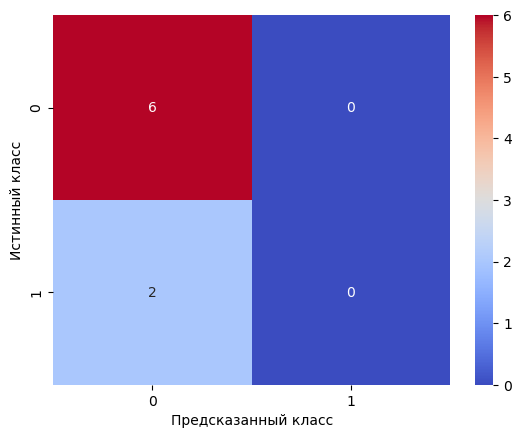

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [191]:
conf_matrix = confusion_matrix(test_data['label'], test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
class_names = ['Содержащий приступ', 'Не содержащий приступ']

plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
plt.figure()

In [193]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.63525 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.36475 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) 


In [195]:
algo = automl.levels[0][0].ml_algos[0]
model = algo.models[0]
print(f'Алгоритм - {type(algo).__name__}\nМодель - {type(model).__name__}\n')

Алгоритм - LinearLBFGS
Модель - TorchBasedLogisticRegression



In [197]:
with open(f'./lightautoml_electrocardiogram_task5_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

In [199]:
with mlflow.start_run(run_name='LAMA'):
    mlflow.log_params(
        {
            'cv': 5,
            'random_state': 42,
            'timeout': 5 * 3600,
            'cpu_limit': 2,
            'algoritm': algo,
            'model': model
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_data['label'], predictions_data),
            'Accuracy test data':  accuracy_score(test_data['label'], test_predictions),
        }
    )
    mlflow.log_artifact('./lightautoml_electrocardiogram_task5_model.pkl')

    model_info = mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lama_model',
        signature=mlflow.models.infer_signature(train_data, predictions_data),
        input_example=train_data,
    )

[22:59:20] Load saved dataset for path


INFO3:lightautoml.transformers.image:Load saved dataset for path


[22:59:20] Feature path transformed


INFO3:lightautoml.transformers.image:Feature path transformed


🏃 View run LAMA at: http://localhost:5000/#/experiments/906824766134576255/runs/aa34fc63de5e46e1890777191b7366f6
🧪 View experiment at: http://localhost:5000/#/experiments/906824766134576255
